# Evaluate Llama3.2 for your RAG system with Unstructured Platform, GPT-4o, Ragas, and LangChain

Author: Nina Lopatina from Unstructured

Nina's X handle: [@NinaLopatina](https://x.com/ninalopatina)

Nina's LinkedIn: https://www.linkedin.com/in/ninalopatina

Last updated: 12.17.24

Llama3 quantized RAG content sections borrowed from [@MariaKhalusova](https://x.com/MariaKhalusova)

## What you'll learn:
1.   No code ETL with Unstructured Platform
2.   Parse Documents w/VLM in S3 -> Pinecone Vector DB + S3
3.   Create a Synthetic Q&A Dataset
4.   Set up a local quantized RAG system with Pinecone + Llama3.2
5.   Evaluate your RAG pipeline with Ragas



In this 8-step tutorial, we're putting these Instruct models head to head for your RAG system:

*   3B Llama3.2 Instruct
*   8B Llama3.1 Instruct
*   8B Llama3 Instruct

This notebook shows how to use [Unstructured Platform](https://unstructured.io/developers) to parse files in an S3 directory, generates a synthetic test data set, sets up RAG with the model of your choice, then evaluates the RAG system's performance across several key [metrics](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/). To compare several models, run through this notebook several times and it will automatically save your results. I found the following results for a 100 question test set for Llama3 vs. 3.1 vs. 3.2:


_________________________________________

In [ ]:
# Do not run this cell again
print(tabulate(df, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))

╒═══════════════════════╤════════════════════════════╤══════════════════════════════╤═════════════════════════╕
│                       │   Meta-Llama-3-8B-Instruct │   Meta-Llama-3.1-8B-Instruct │   Llama-3.2-3B-Instruct │
╞═══════════════════════╪════════════════════════════╪══════════════════════════════╪═════════════════════════╡
│ faithfulness          │                     0.6006 │                       0.6321 │                  0.5896 │
├───────────────────────┼────────────────────────────┼──────────────────────────────┼─────────────────────────┤
│ semantic_similarity   │                     0.9168 │                       0.9115 │                  0.9070 │
├───────────────────────┼────────────────────────────┼──────────────────────────────┼─────────────────────────┤
│ factual_correctness   │                     0.3122 │                       0.2887 │                  0.2842 │
├───────────────────────┼────────────────────────────┼──────────────────────────────┼───────────────────

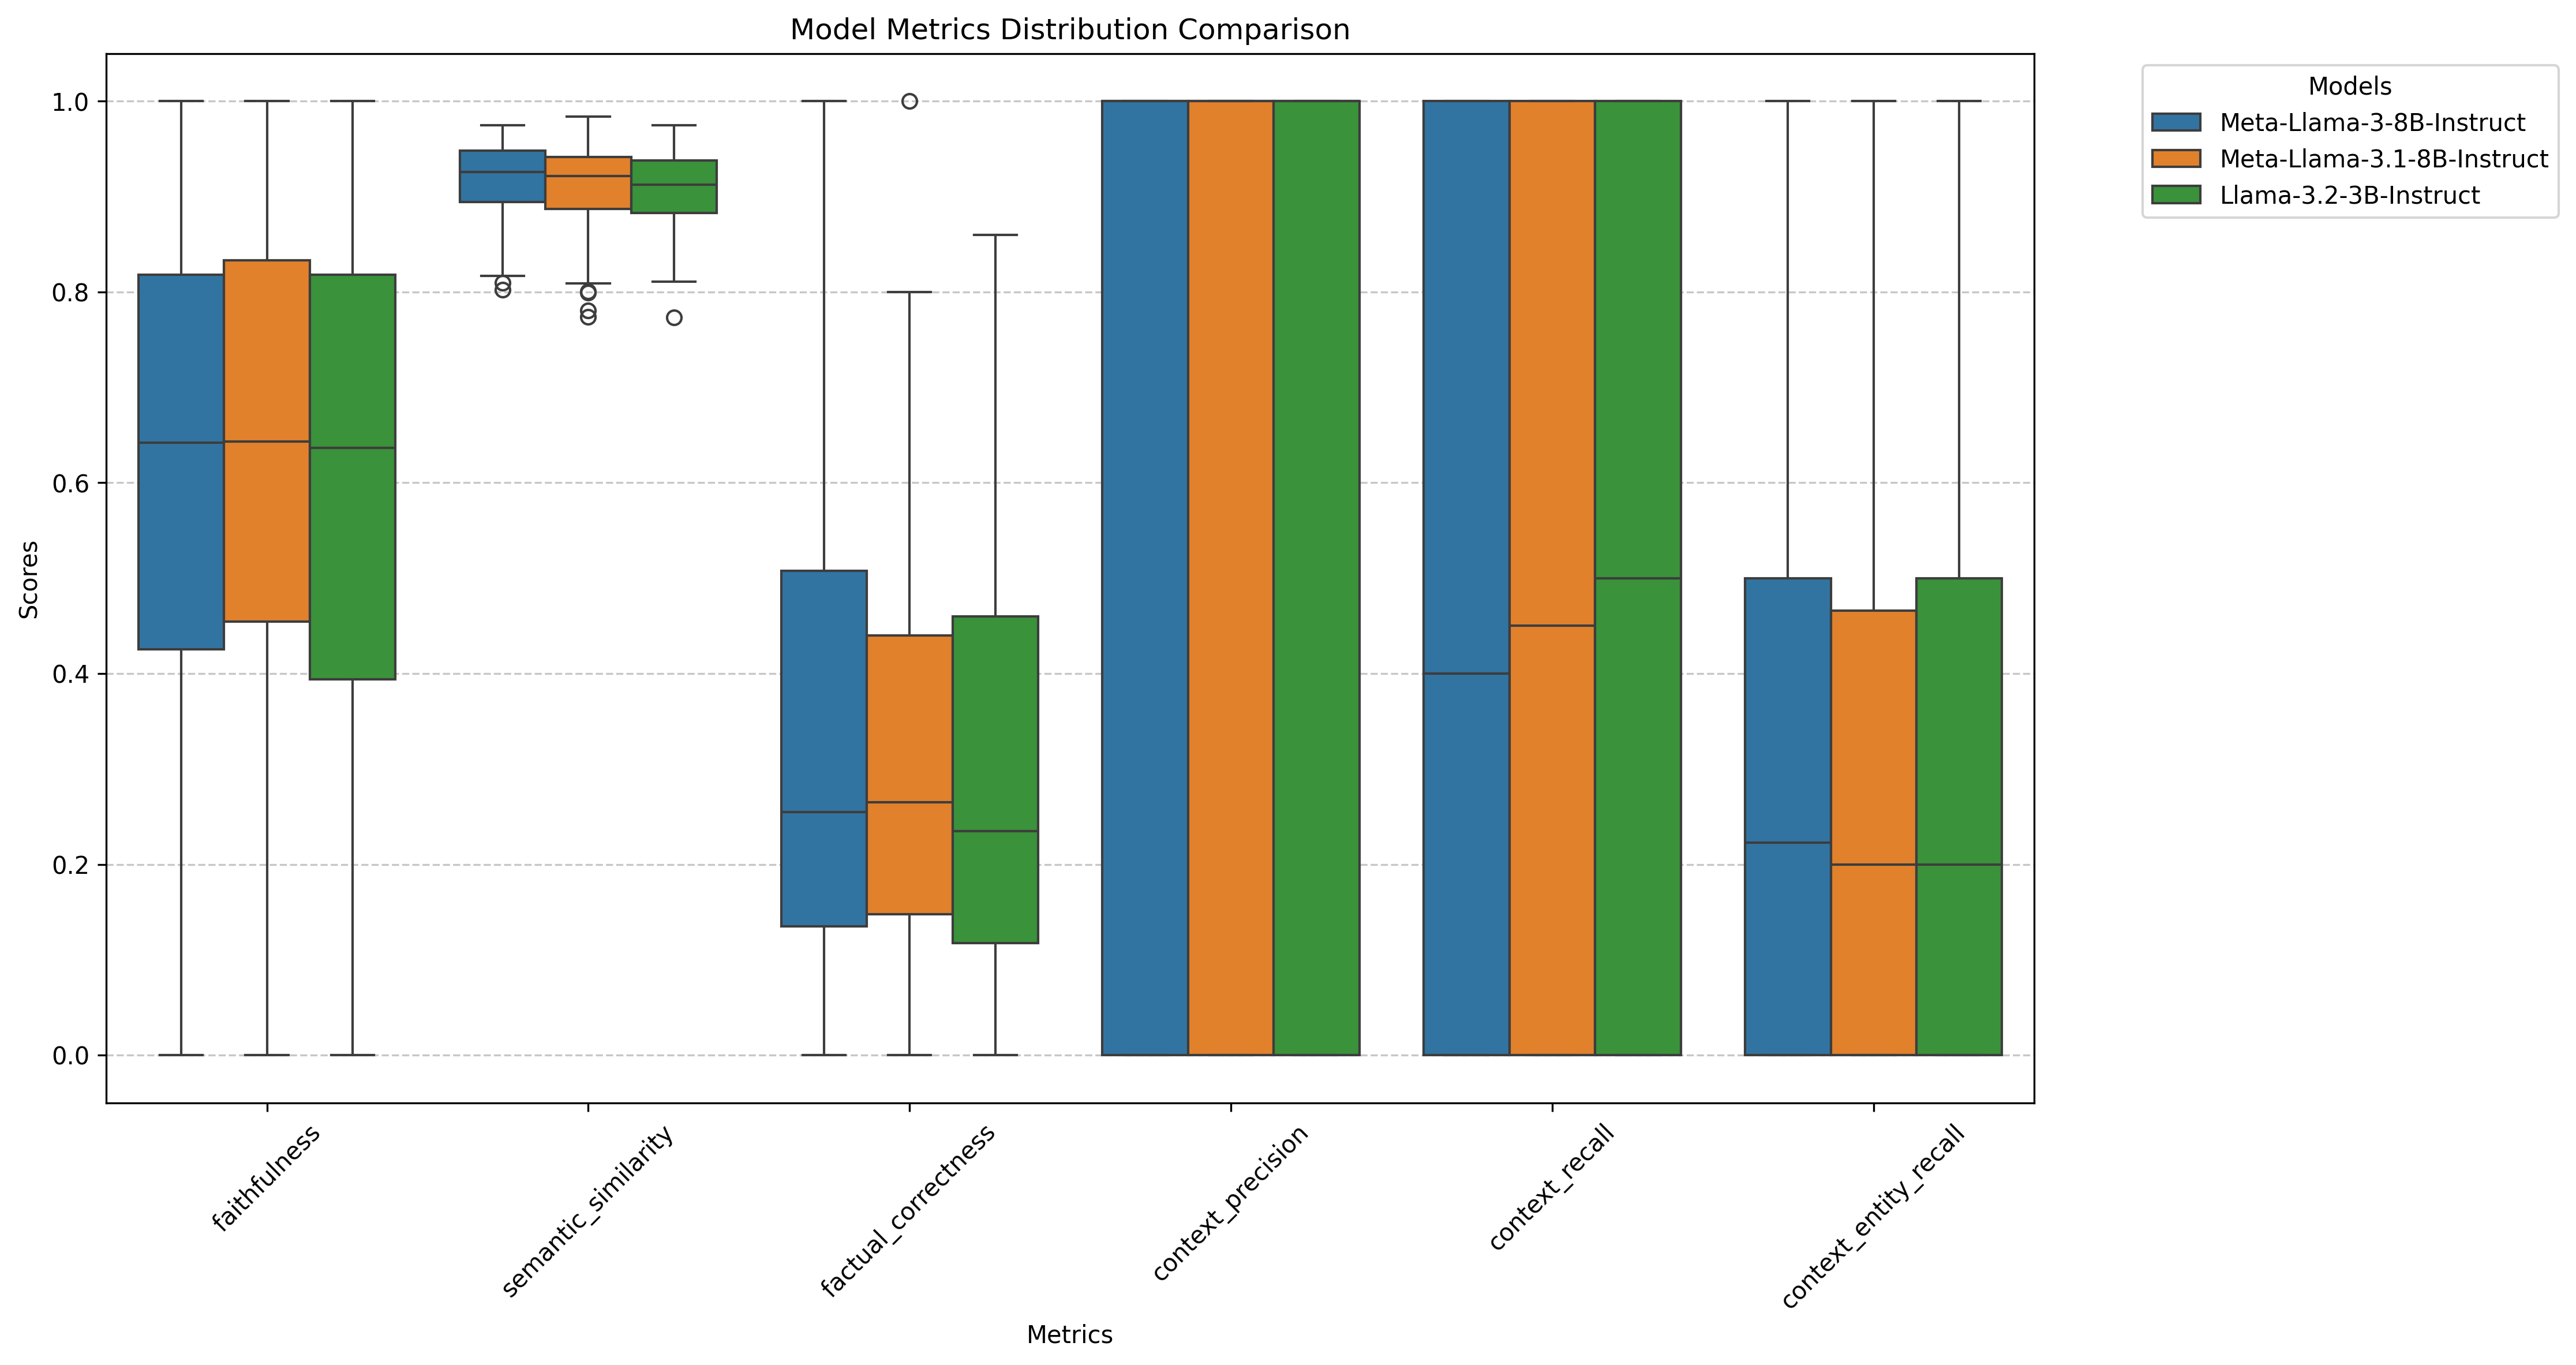

In [ ]:
# Do not run this cell again
# Visualize metrics
from IPython.display import Image
Image('boxplot.png')

Note that this is a small sample, we just tested a small set of questions on one paper -- but this is a compelling preliminary result, that I would follow with a subjective evaluation + larger scale evaluation, before deciding to update a model running in production.

In this tutorial, we will first demonstrate how easily your pdfs can be transformed into meaningfully chunked text segments to create data and a RAG system from via Unstructured's Platform. Leveraging the Ragas evaluation framework, this synthetic test dataset enables evaluation of your Llama3 RAG system's performance.

Evaluating RAG systems comprehensively is challenging due to the need to have many custom questions and answers per document on which to evaluate performance. Rather than having human labelers pore over long documents, these can be created synthetically with a powerful, cost effective model like GPT-4o. GPT-4 has long been the standard for challenging tasks like creating synthetic test datasets for RAG, and the recent release of GPT-4o brings the cost down x2 and speed up x2, in addition to improvements across 50 languages!

However, even GPT-4o by default is not good at creating diverse samples as it tends to follow common paths. Ragas expands upon this by employing an evolutionary generation paradigm, where questions with different characteristics such as reasoning, conditioning, multi-context, and more are systematically crafted from the provided set of documents.

We'll use [Unstructured Platform](https://unstructured.io/developers) for preprocessing PDF files stored in S3, Ragas for the [test set generation](https://docs.ragas.io/en/latest/getstarted/rag_testset_generation/) and [evaluation](https://docs.ragas.io/en/latest/getstarted/rag_evaluation/) framework, [OpenAI's GPT-4o](https://platform.openai.com/docs/models) to do the Q & A data generation. We'll build a simple RAG system with the latest LLM from Meta - Llama 3.2, specifically the `Llama-3.2-3B-Instruct` version that you can get on Hugging Face, [Pinecone](https://www.pinecone.io/) for vector storage, and HuggingFace `transformers` to get the model, and [LangChain](https://www.langchain.com/) for integration.

For this demo, we have uploaded a pdf dataset from Kaggle, of papers from [CVPR 2019](https://www.kaggle.com/datasets/paultimothymooney/cvpr-2019-papers), to S3. Though these were available before the knowledge
_________________________________________

1. To get started, let's set up our source, destination, and workflow in Unstructured Platform! You can sign up for [Unstructured Platform](https://unstructured.io/developers) with a 14 day free trial!!

Documentation: https://docs.unstructured.io/platform/overview

Create a new source at https://platform.unstructured.io/connectors/editor/new/sources and fill in as per https://docs.unstructured.io/platform/sources/s3



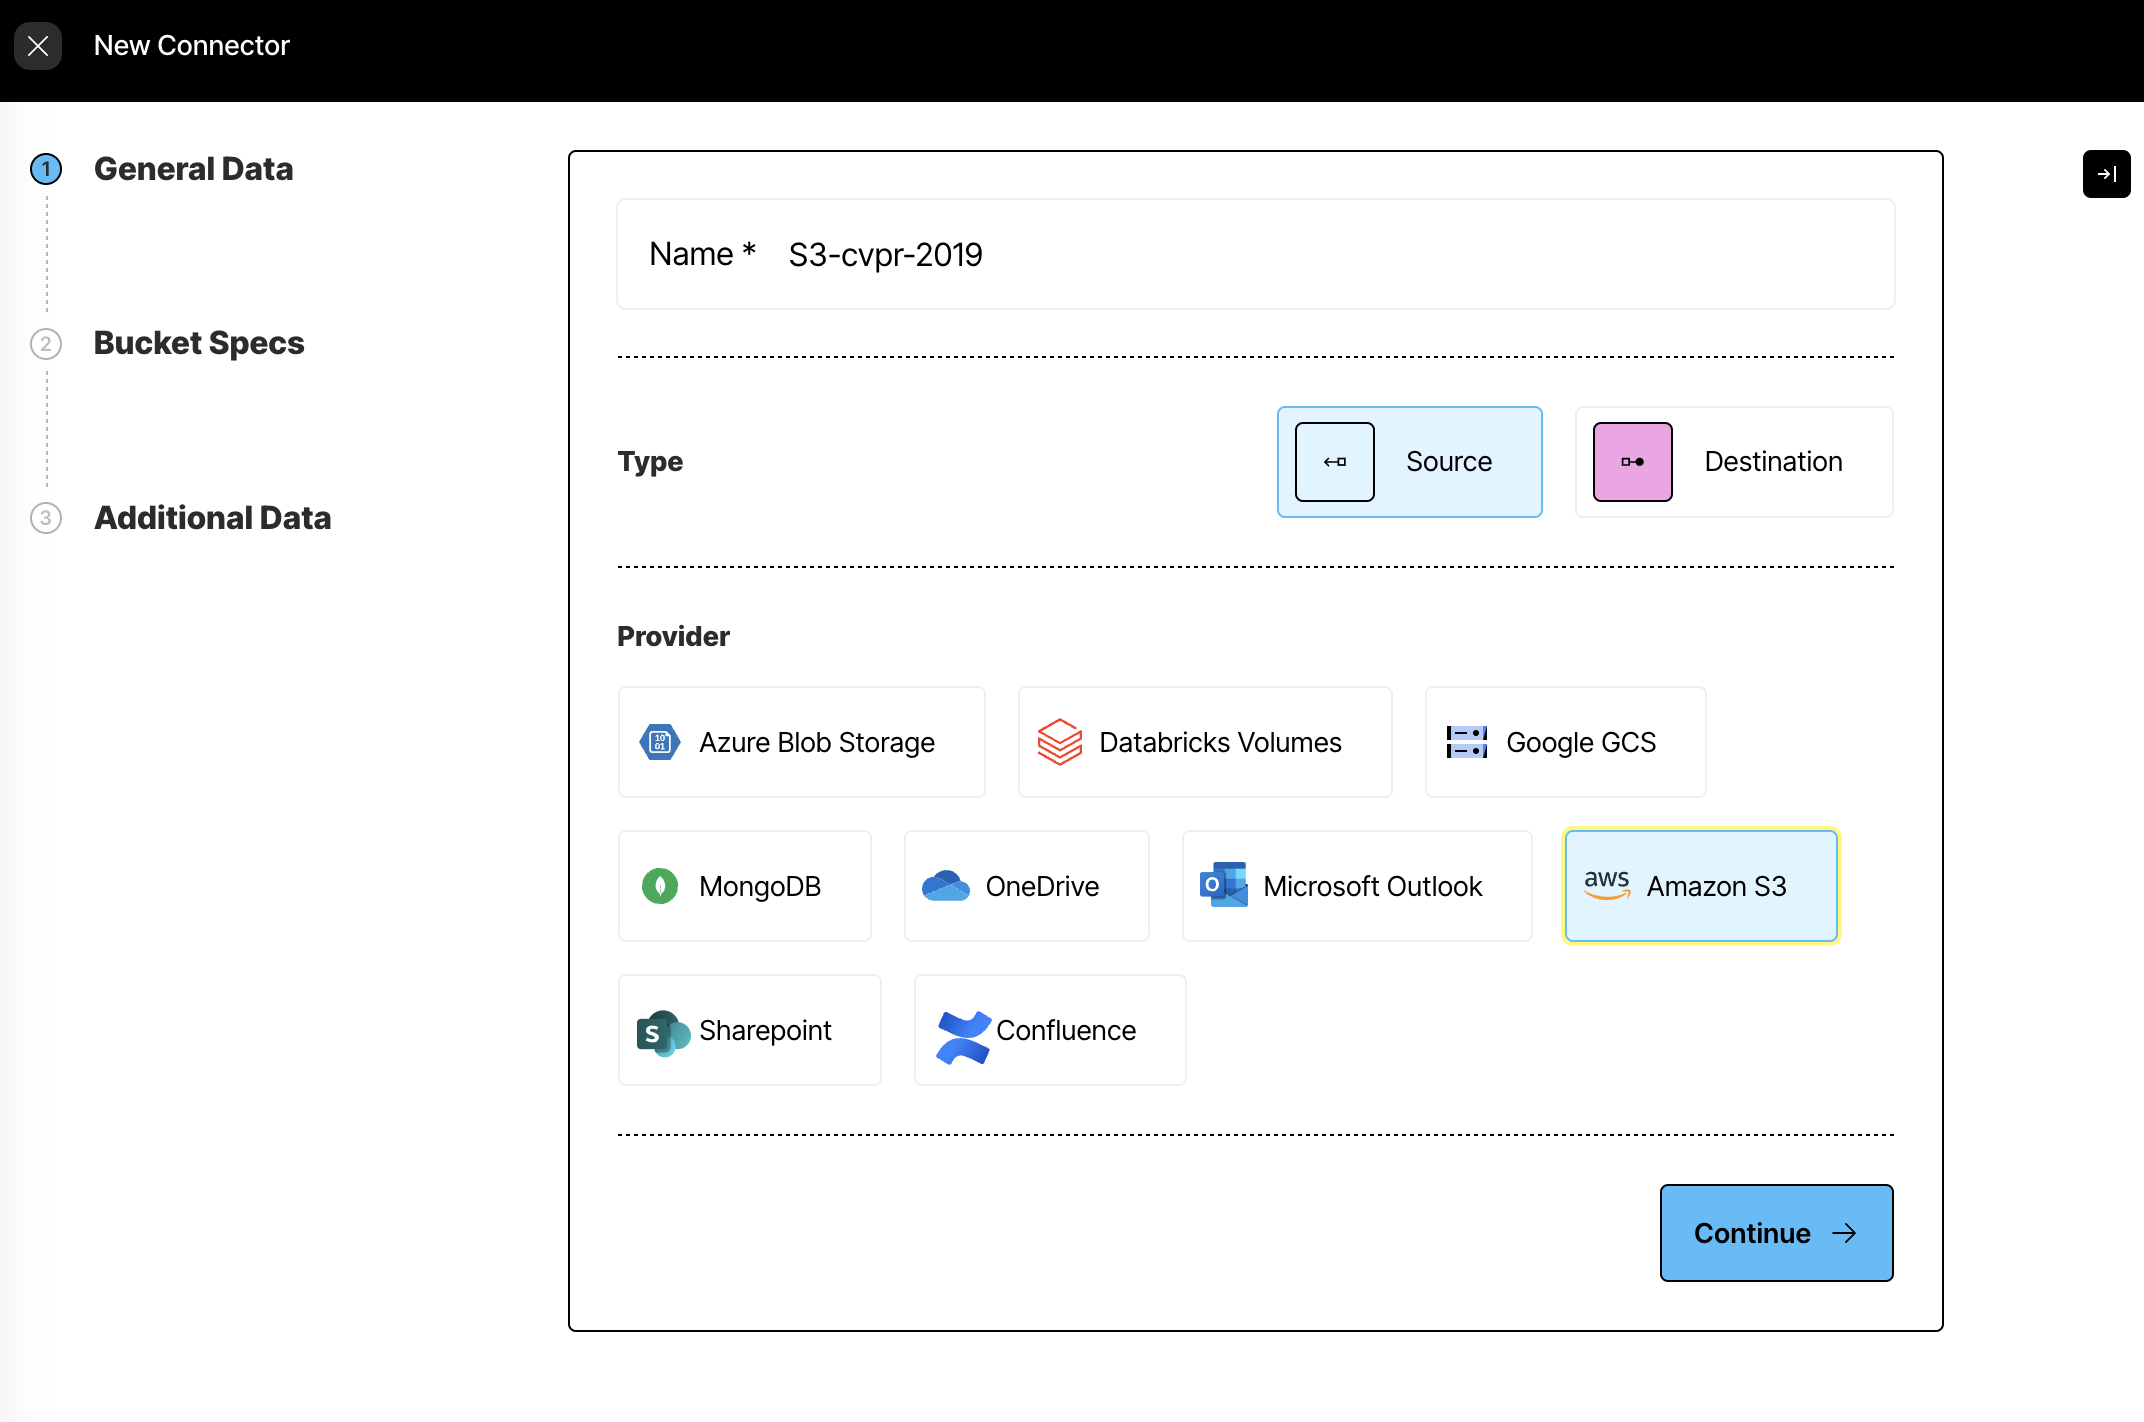

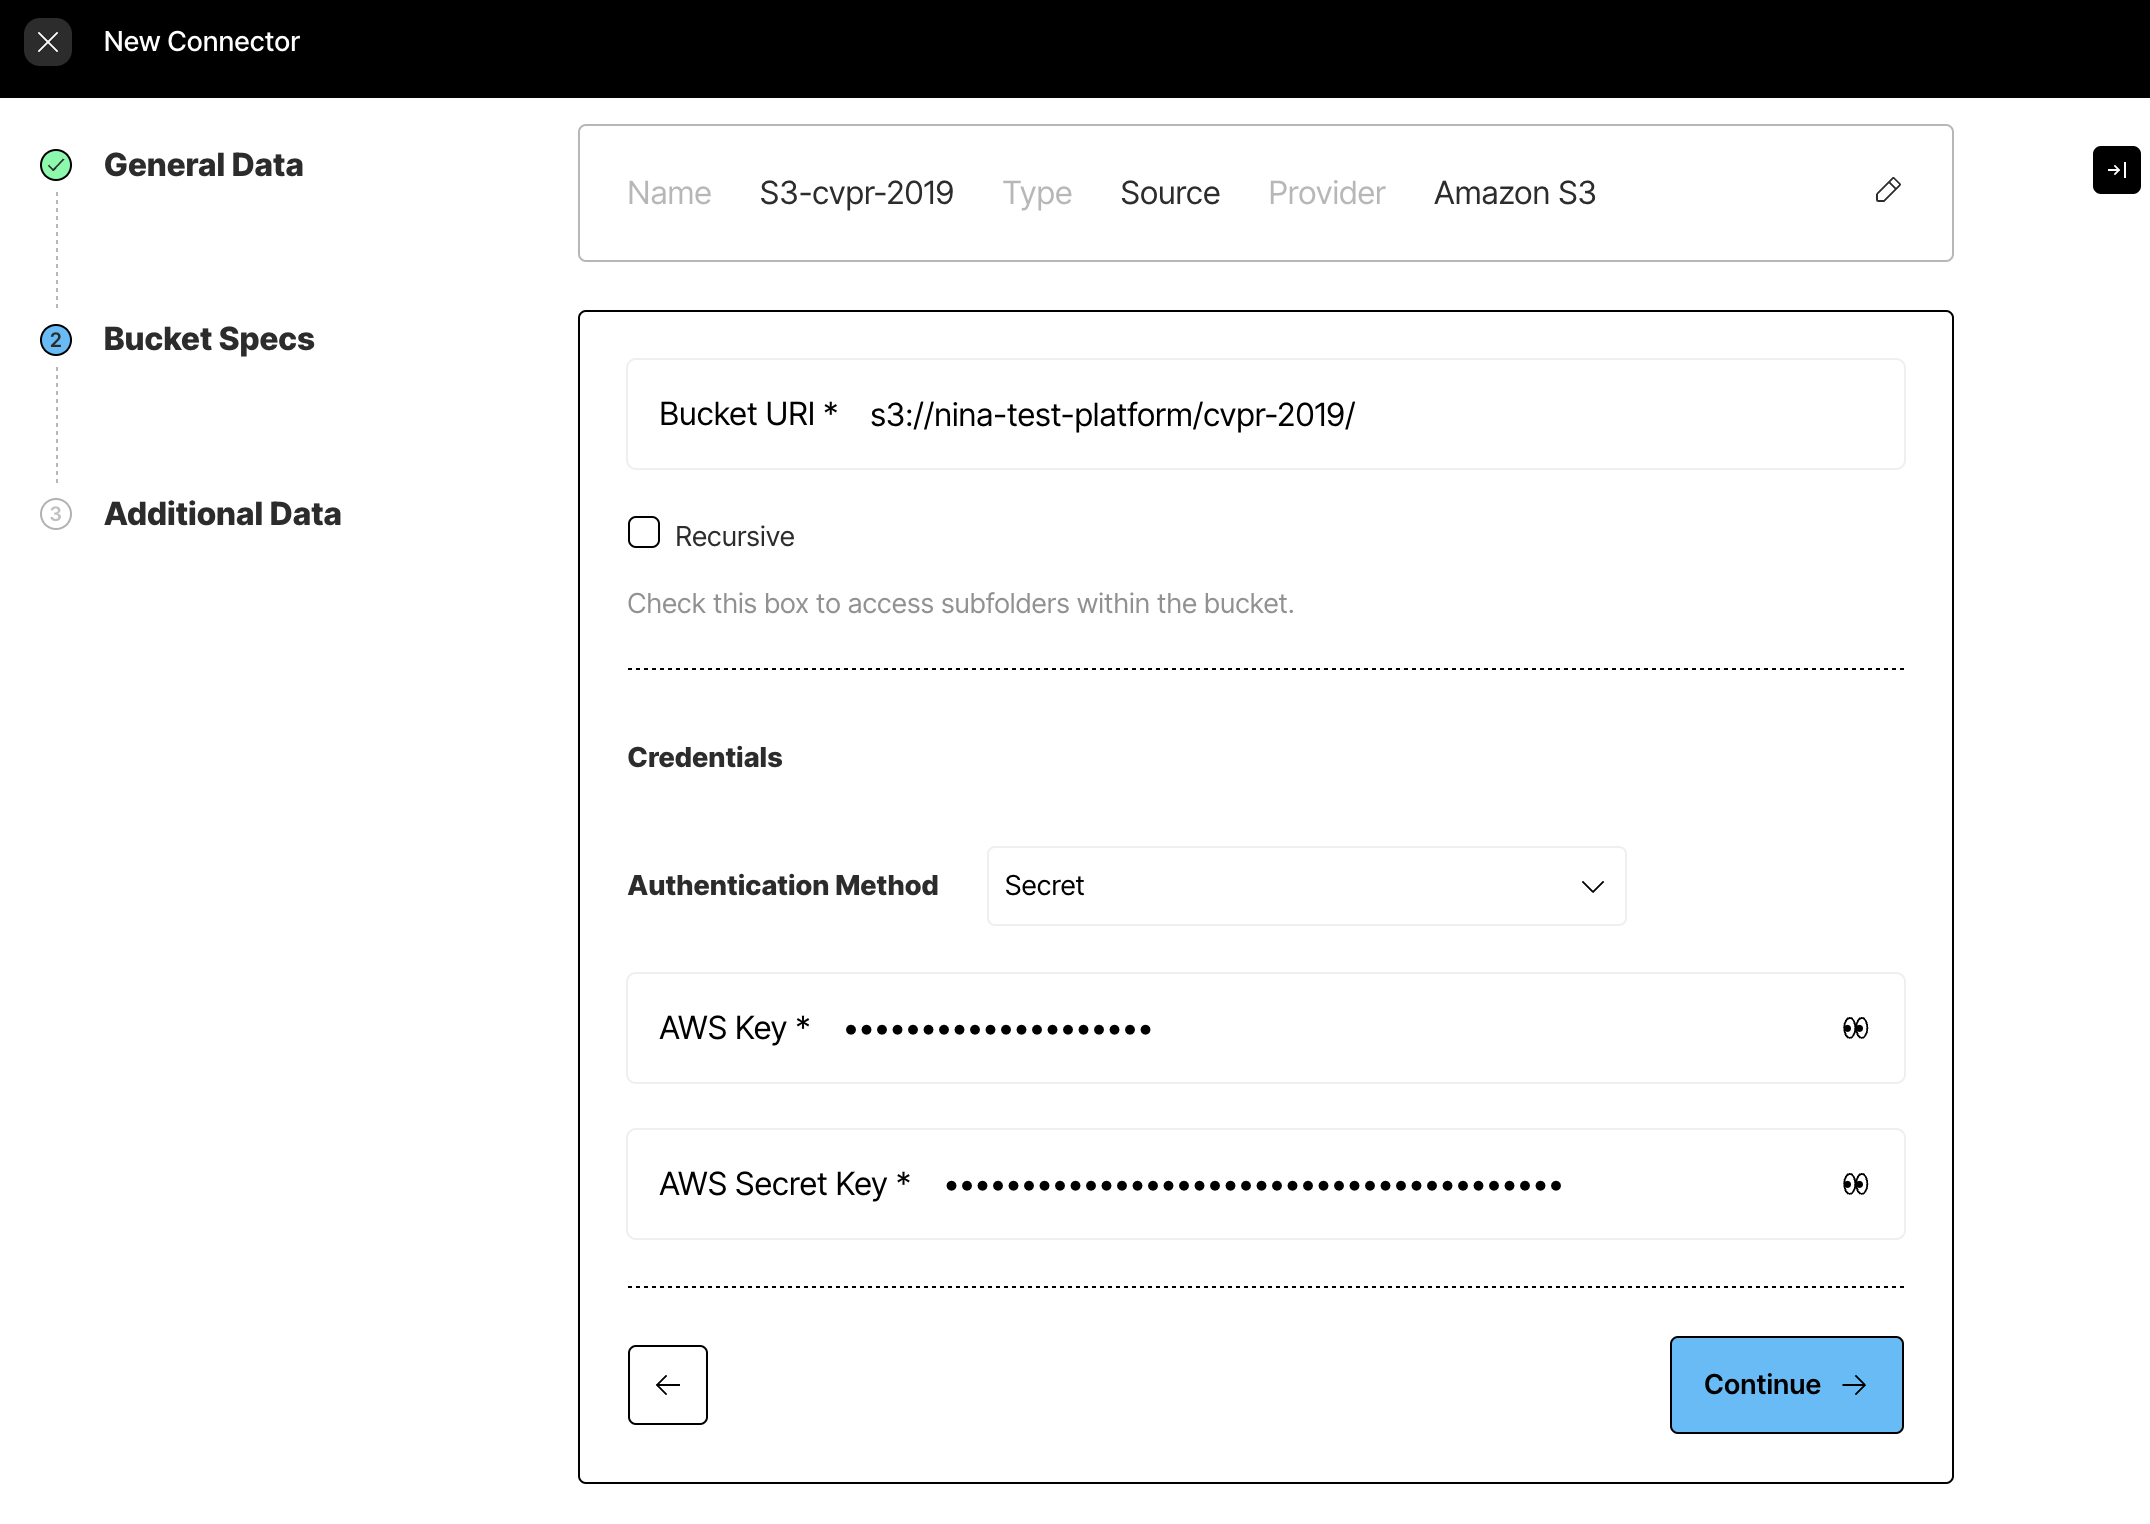

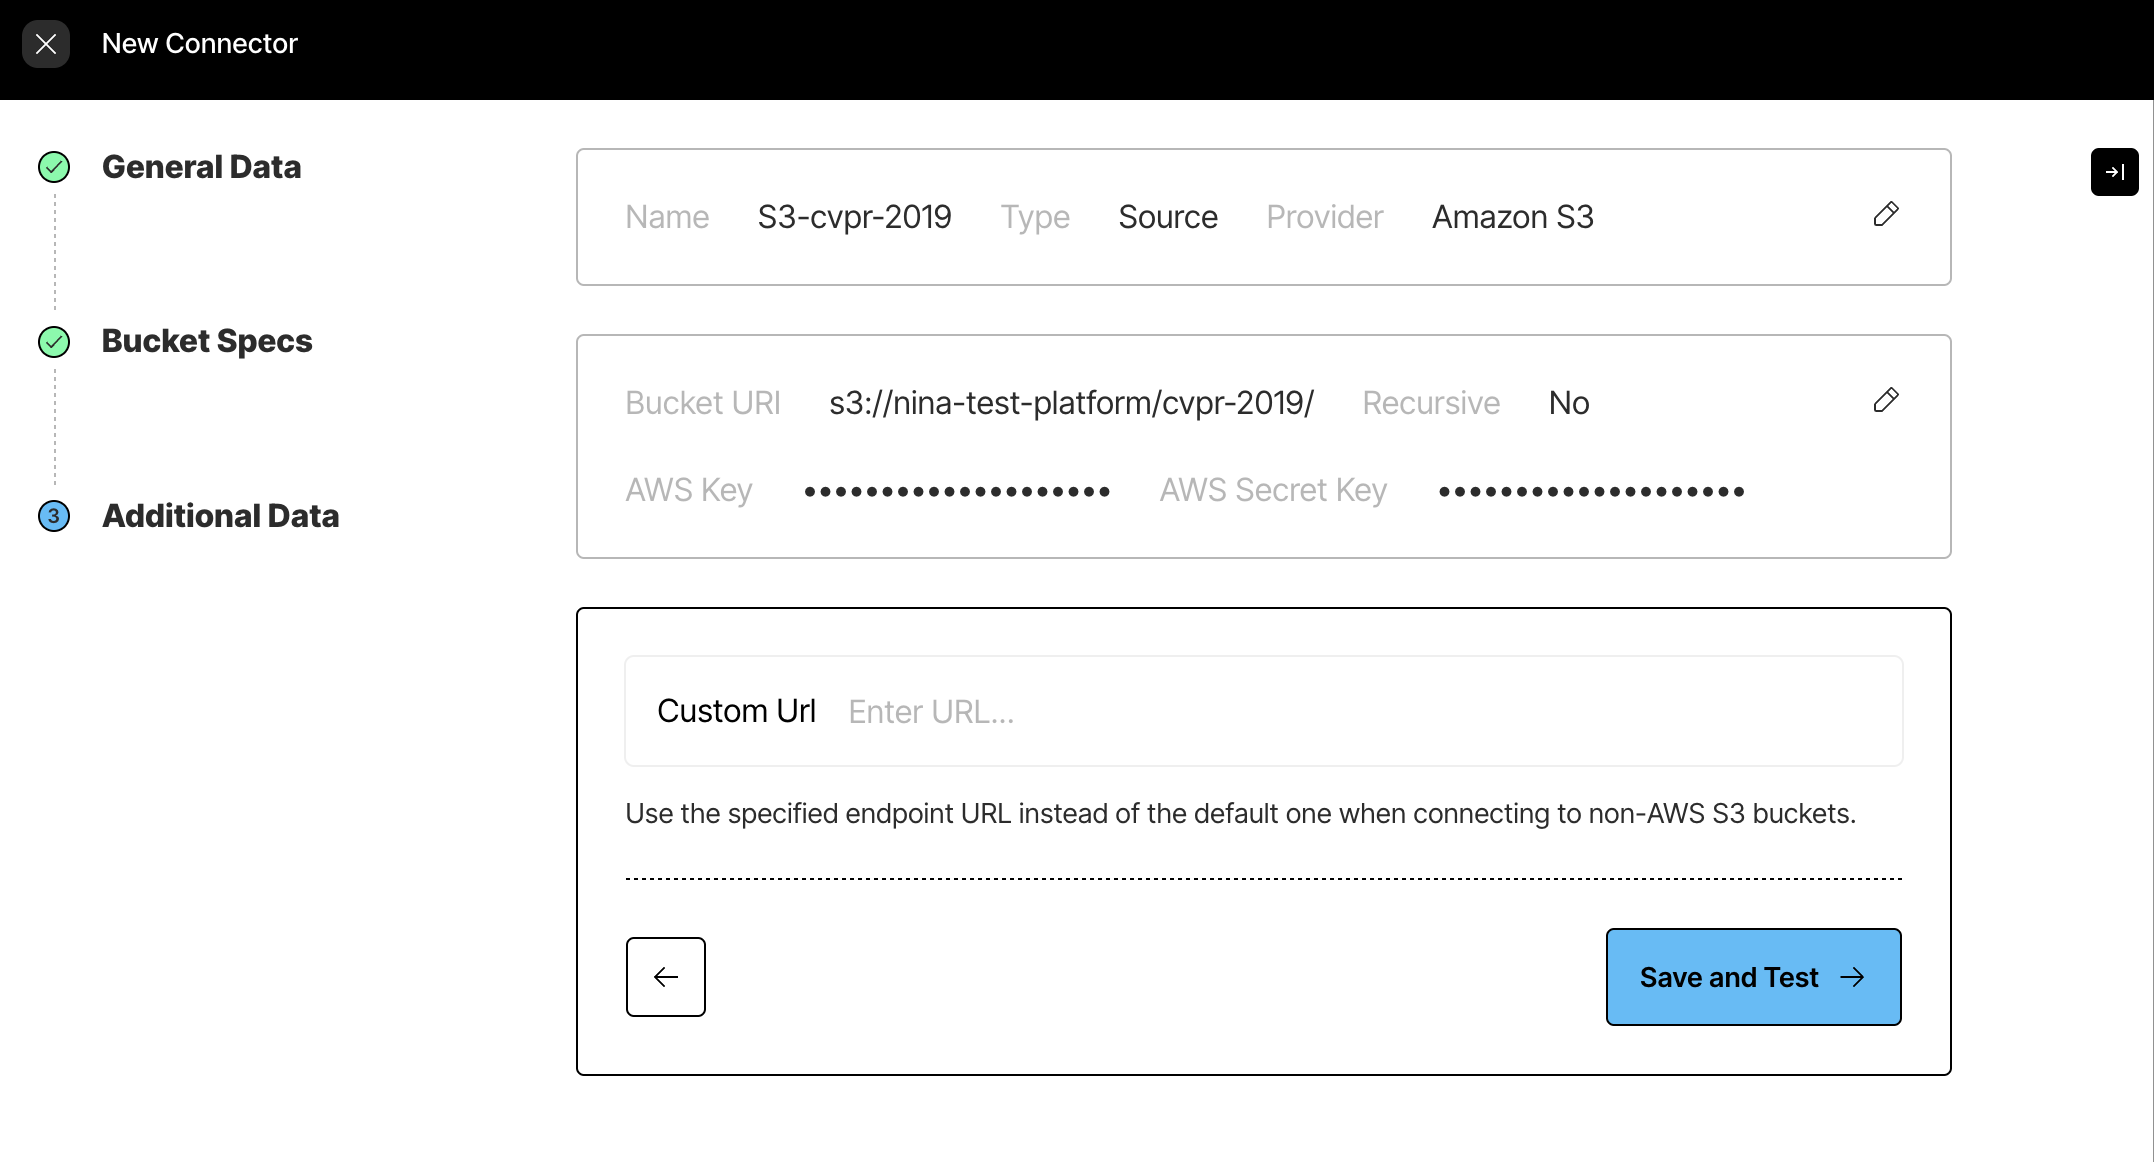

Then you will see if your connector was successfully saved under your list of Source connectors.

Create a new destination at https://platform.unstructured.io/connectors/editor/new/destinations and fill in as per https://docs.unstructured.io/platform/destinations/pinecone. Since we are using Pinecone, you can get the info you need at https://app.pinecone.io/?sessionType=login


I set up the destination with my embedding dimension in mind: Ada 002 (text) with dimensions of 1536.


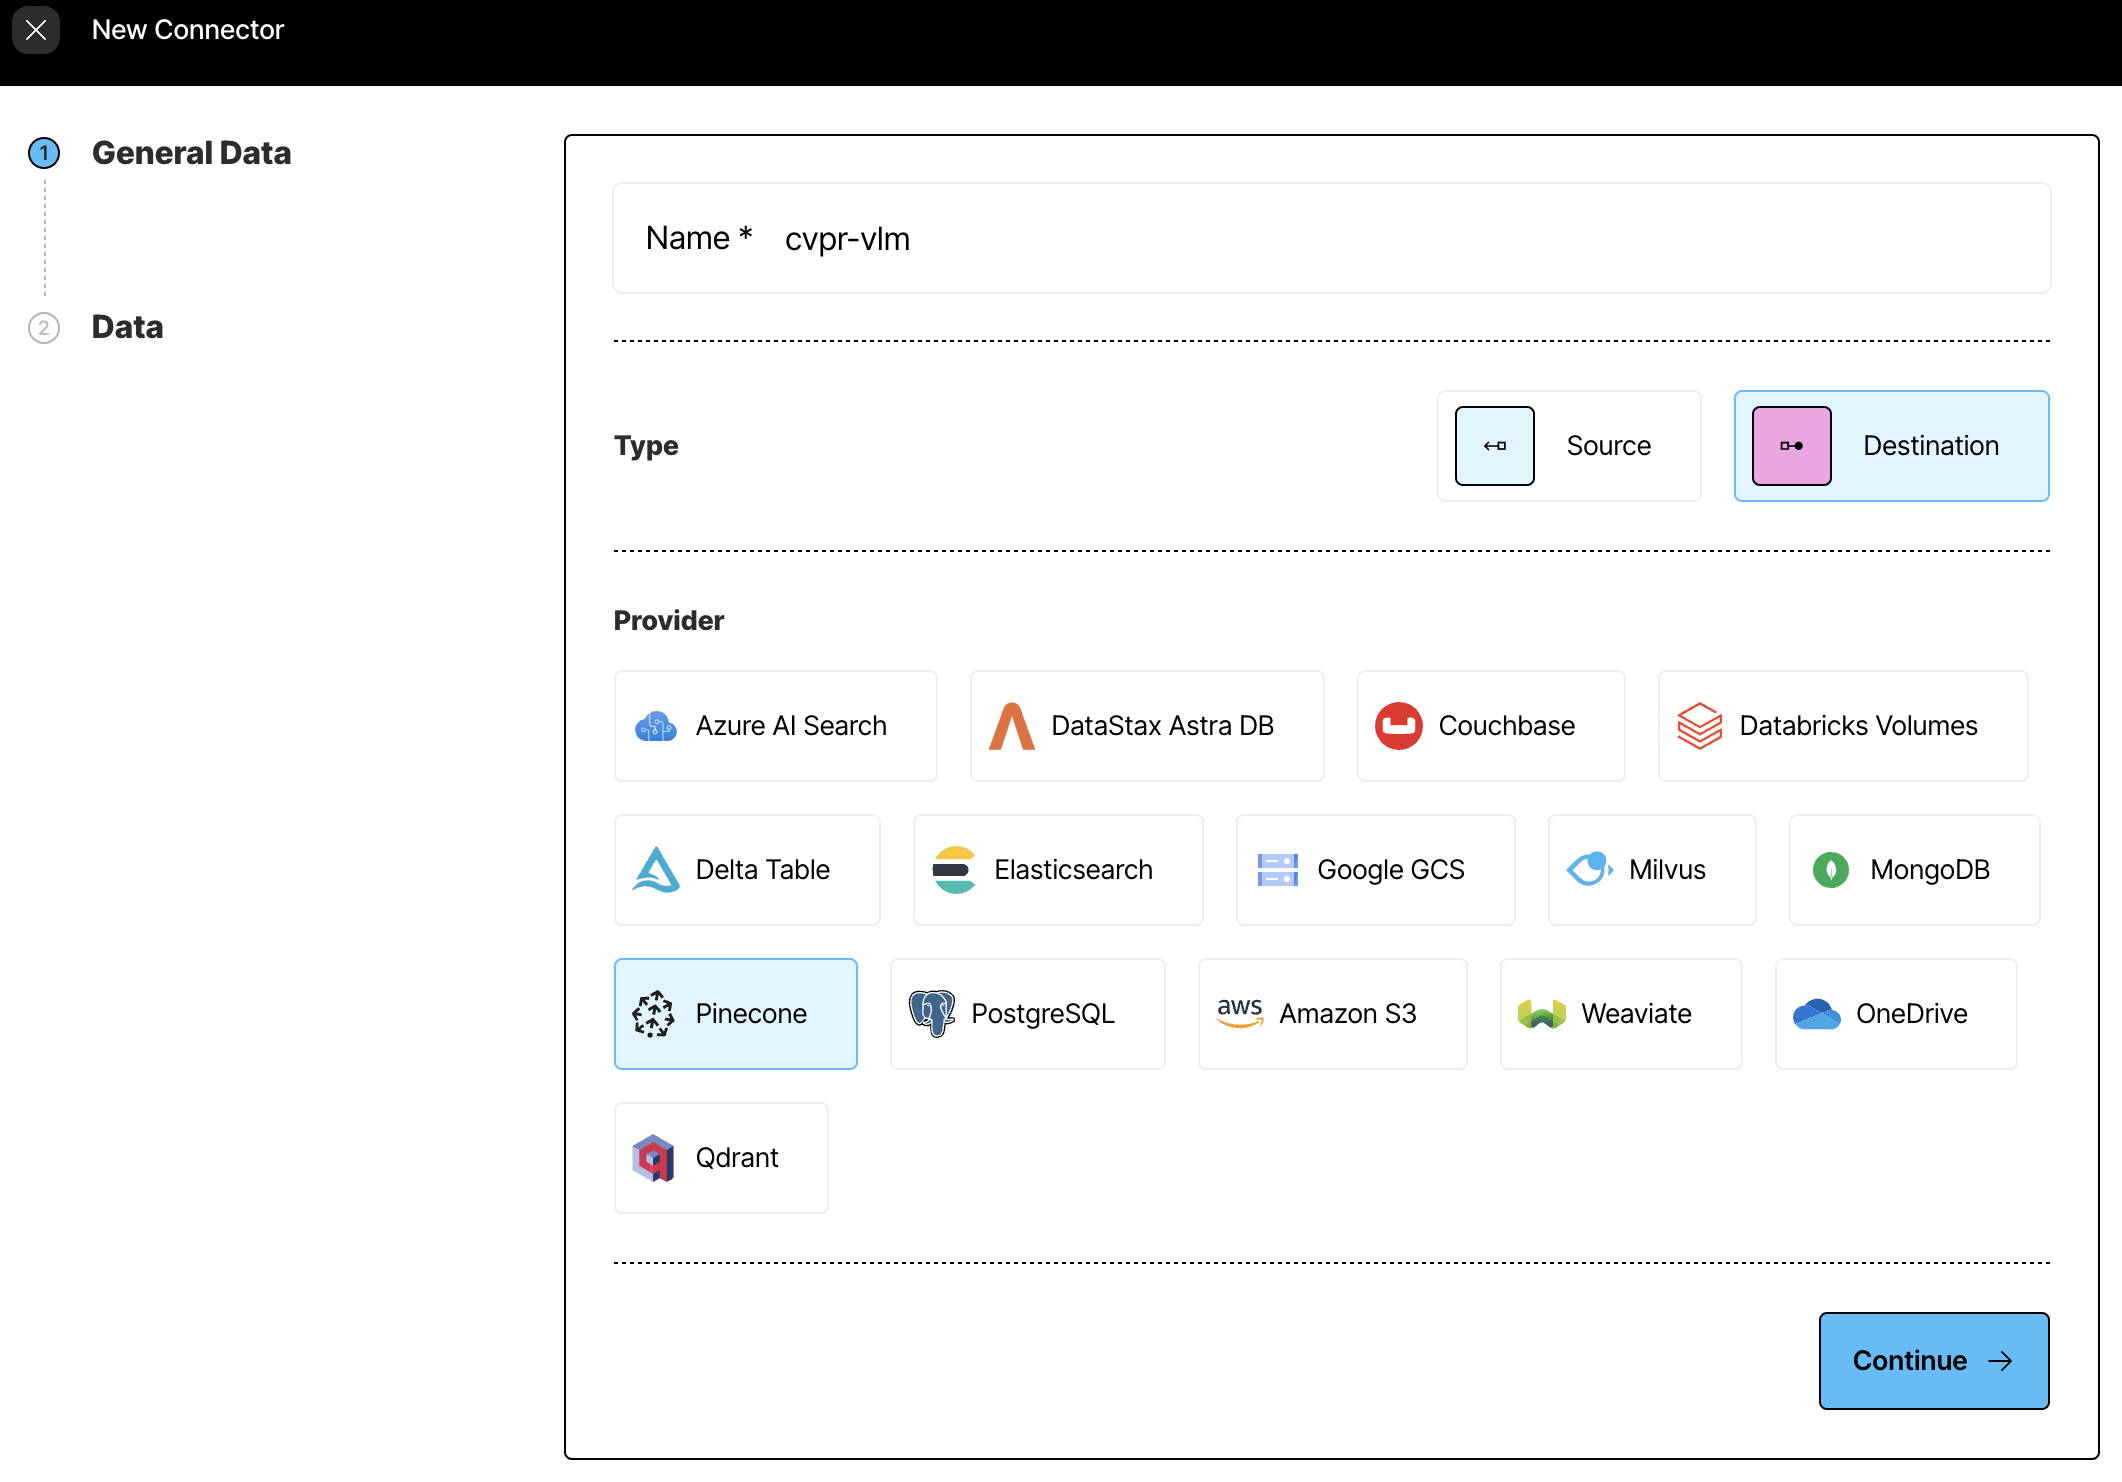

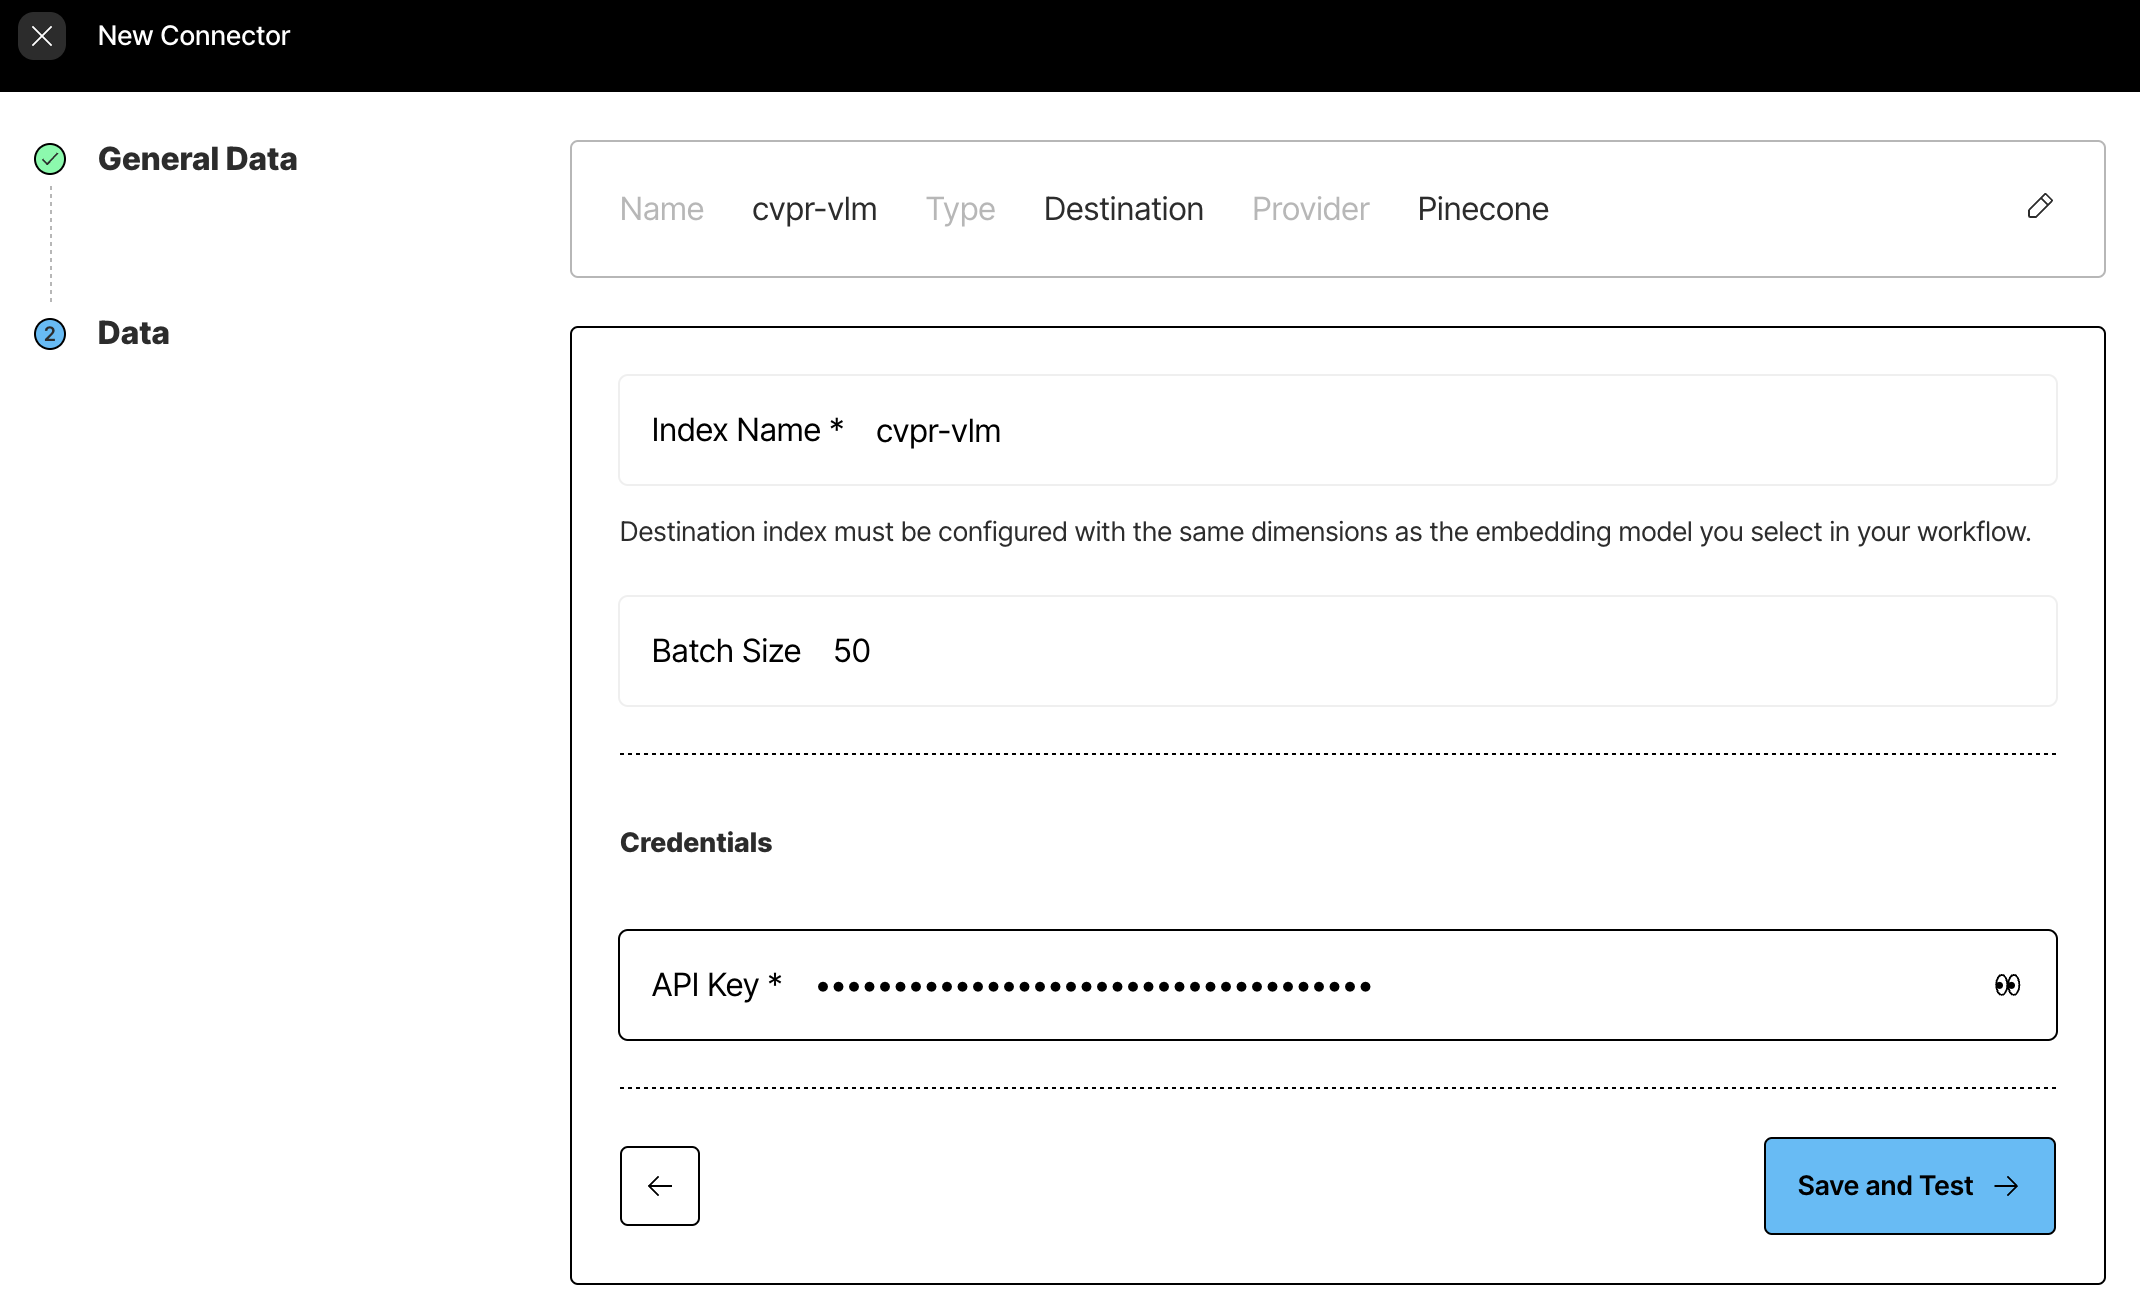

We’re going to create an S3 destination using the same process as step 1, just selecting S3 as a destination.
Let’s set up our workflow at https://platform.unstructured.io/workflows/new


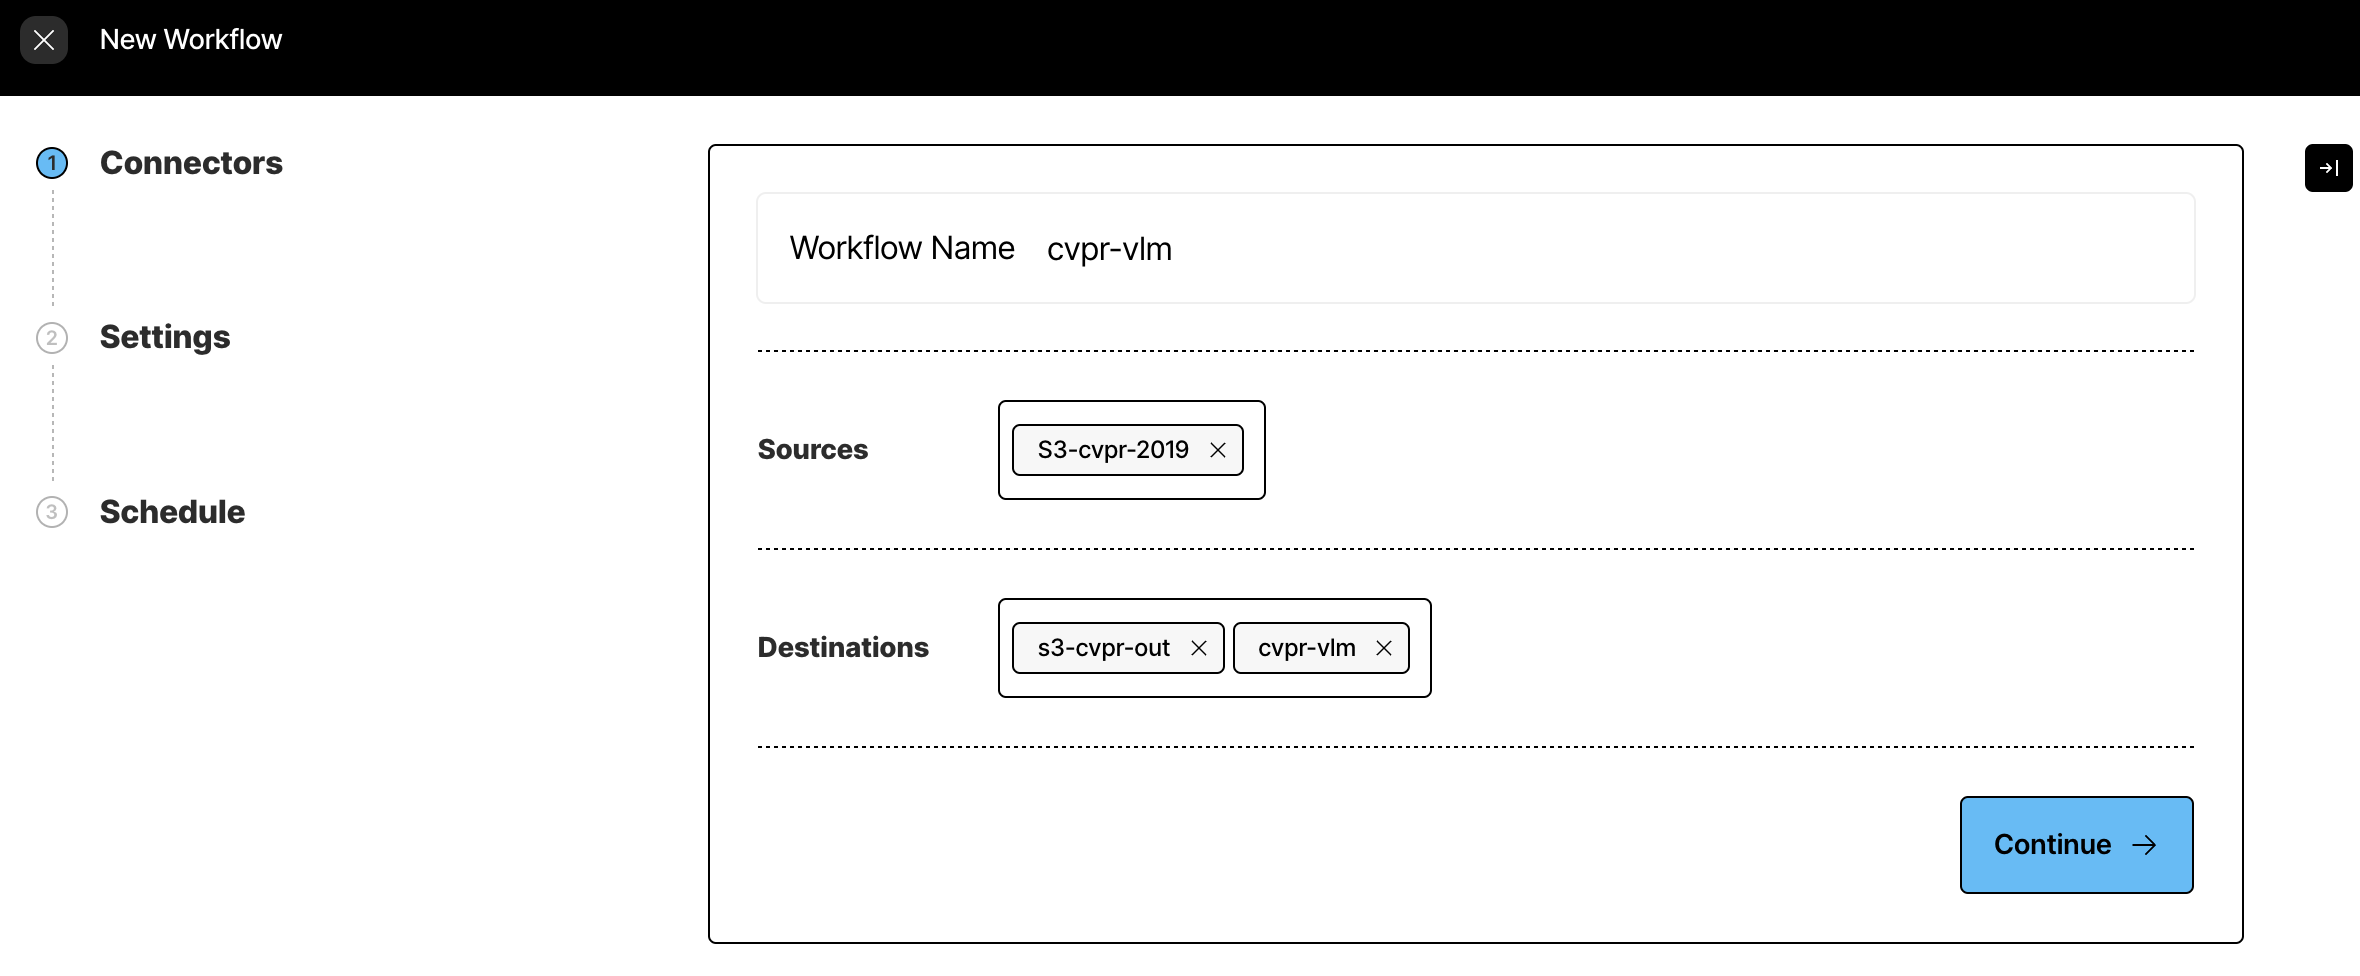

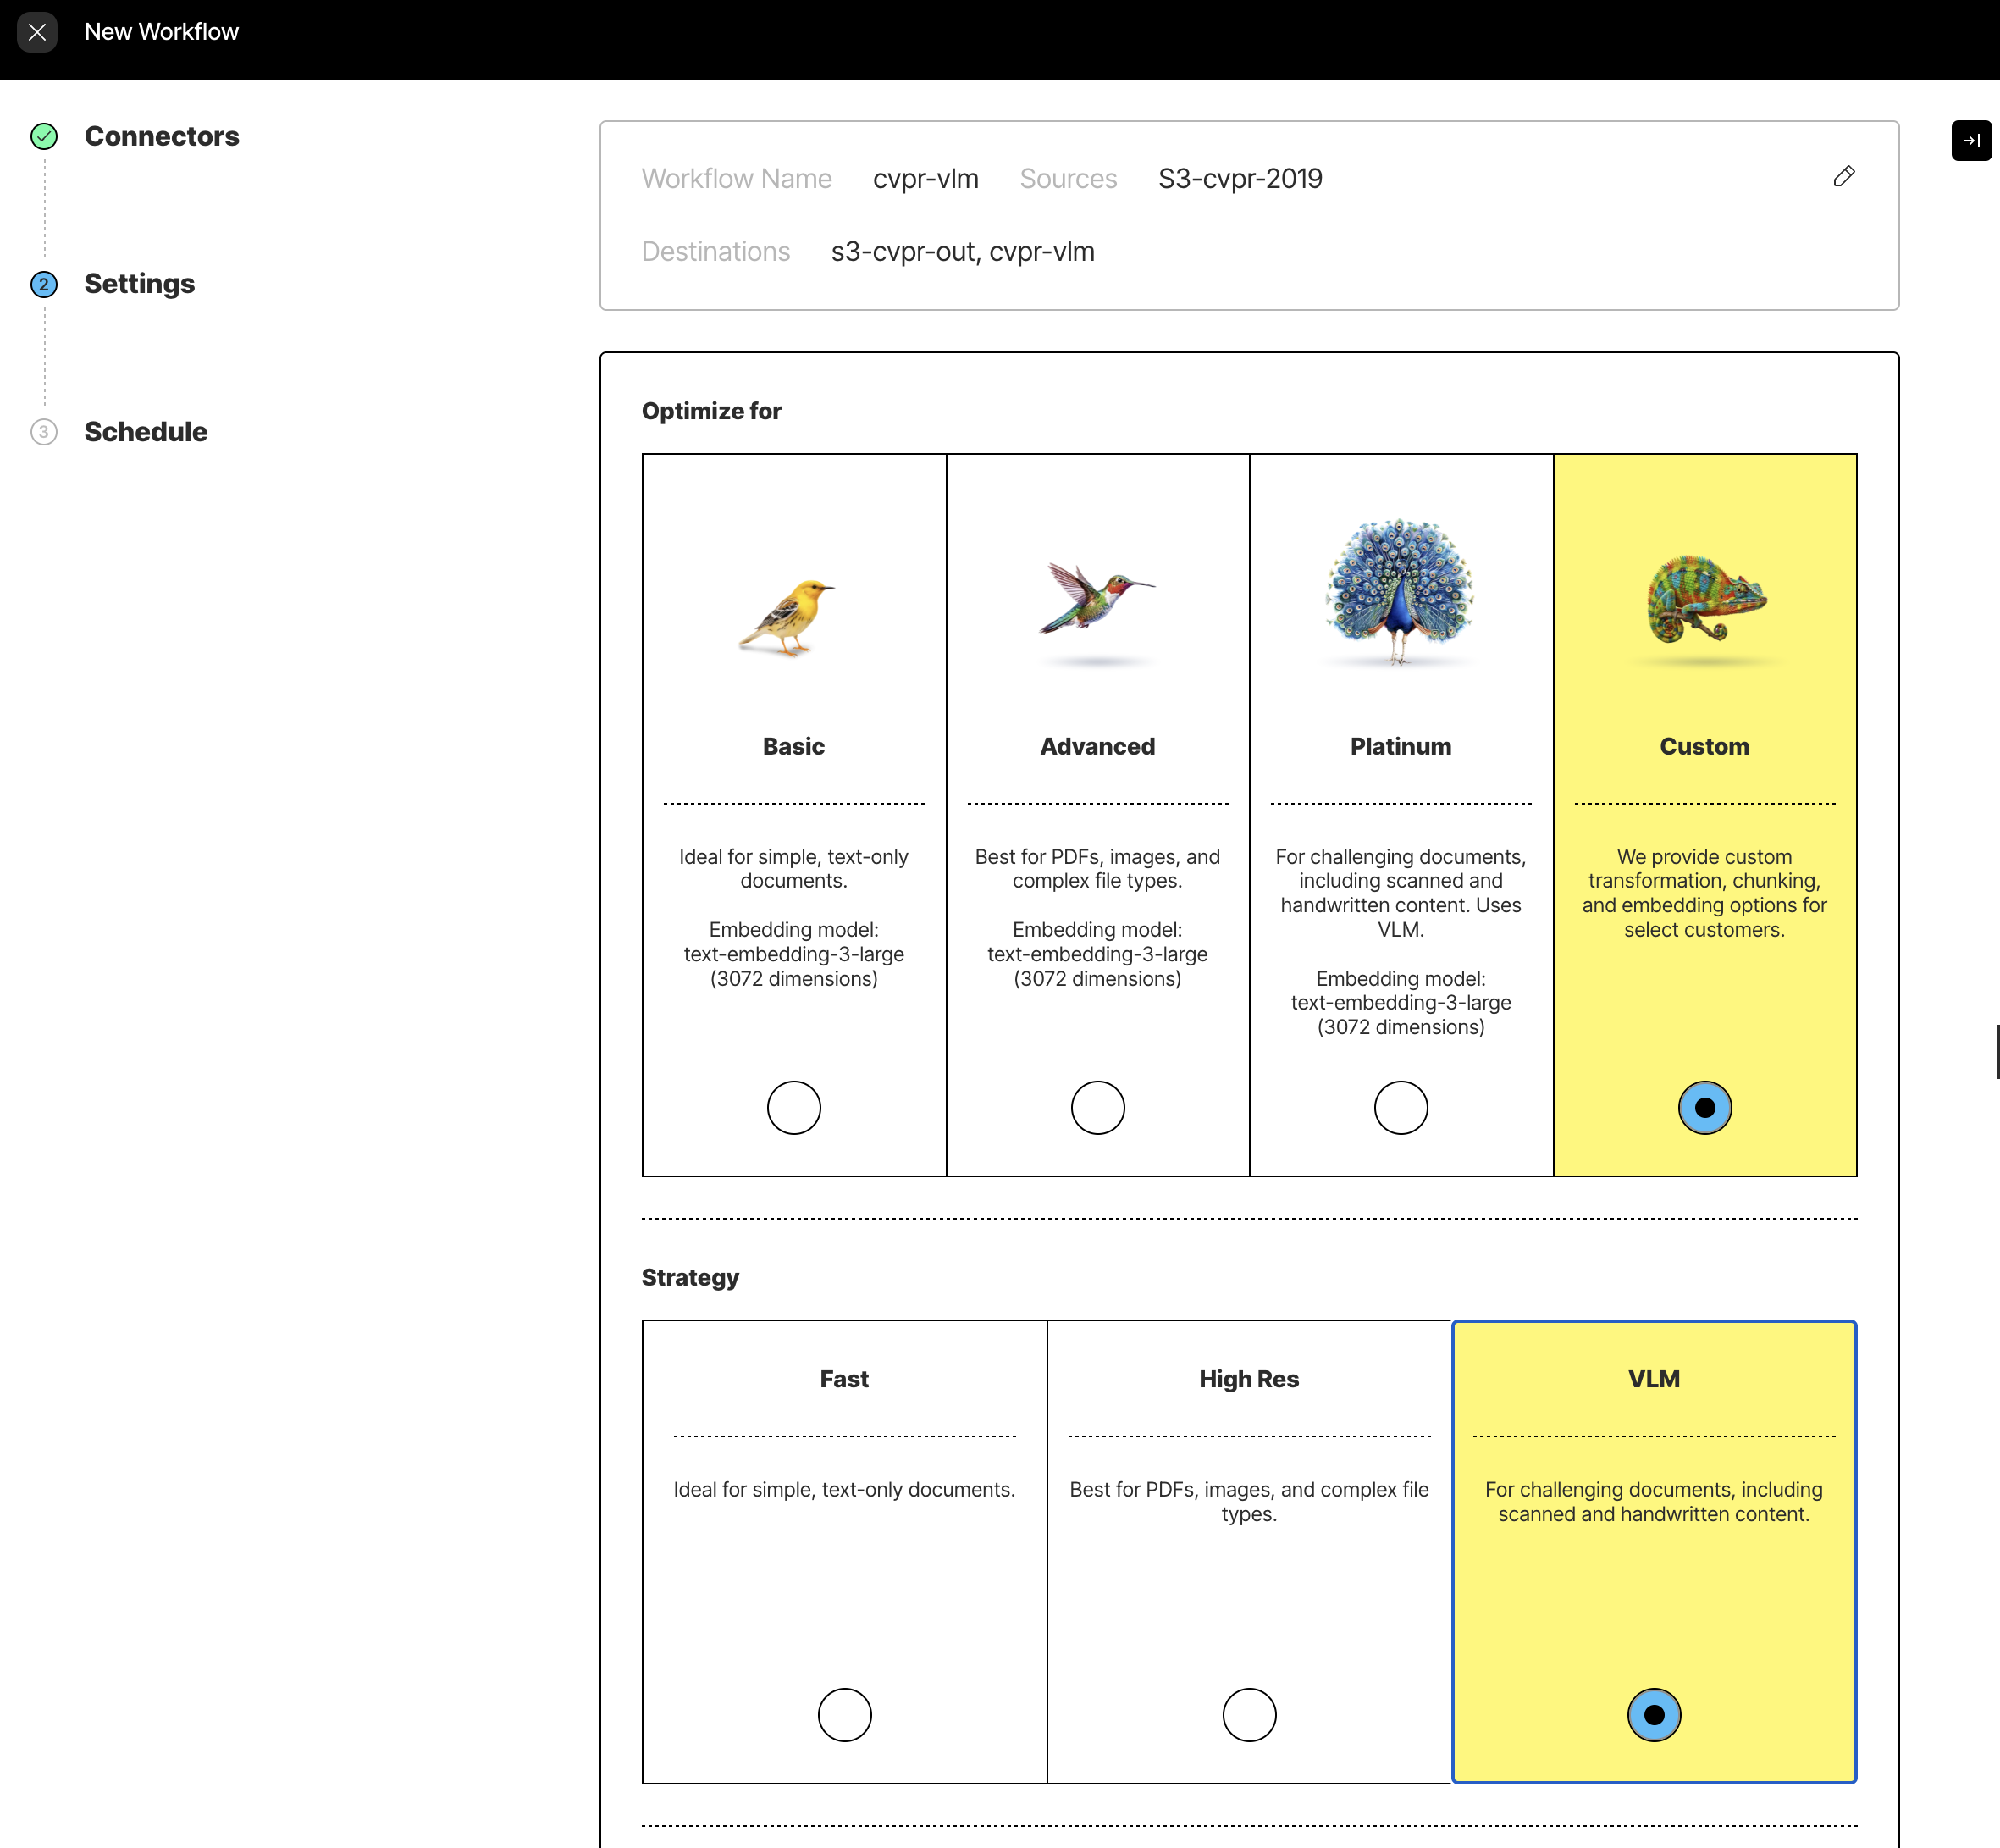

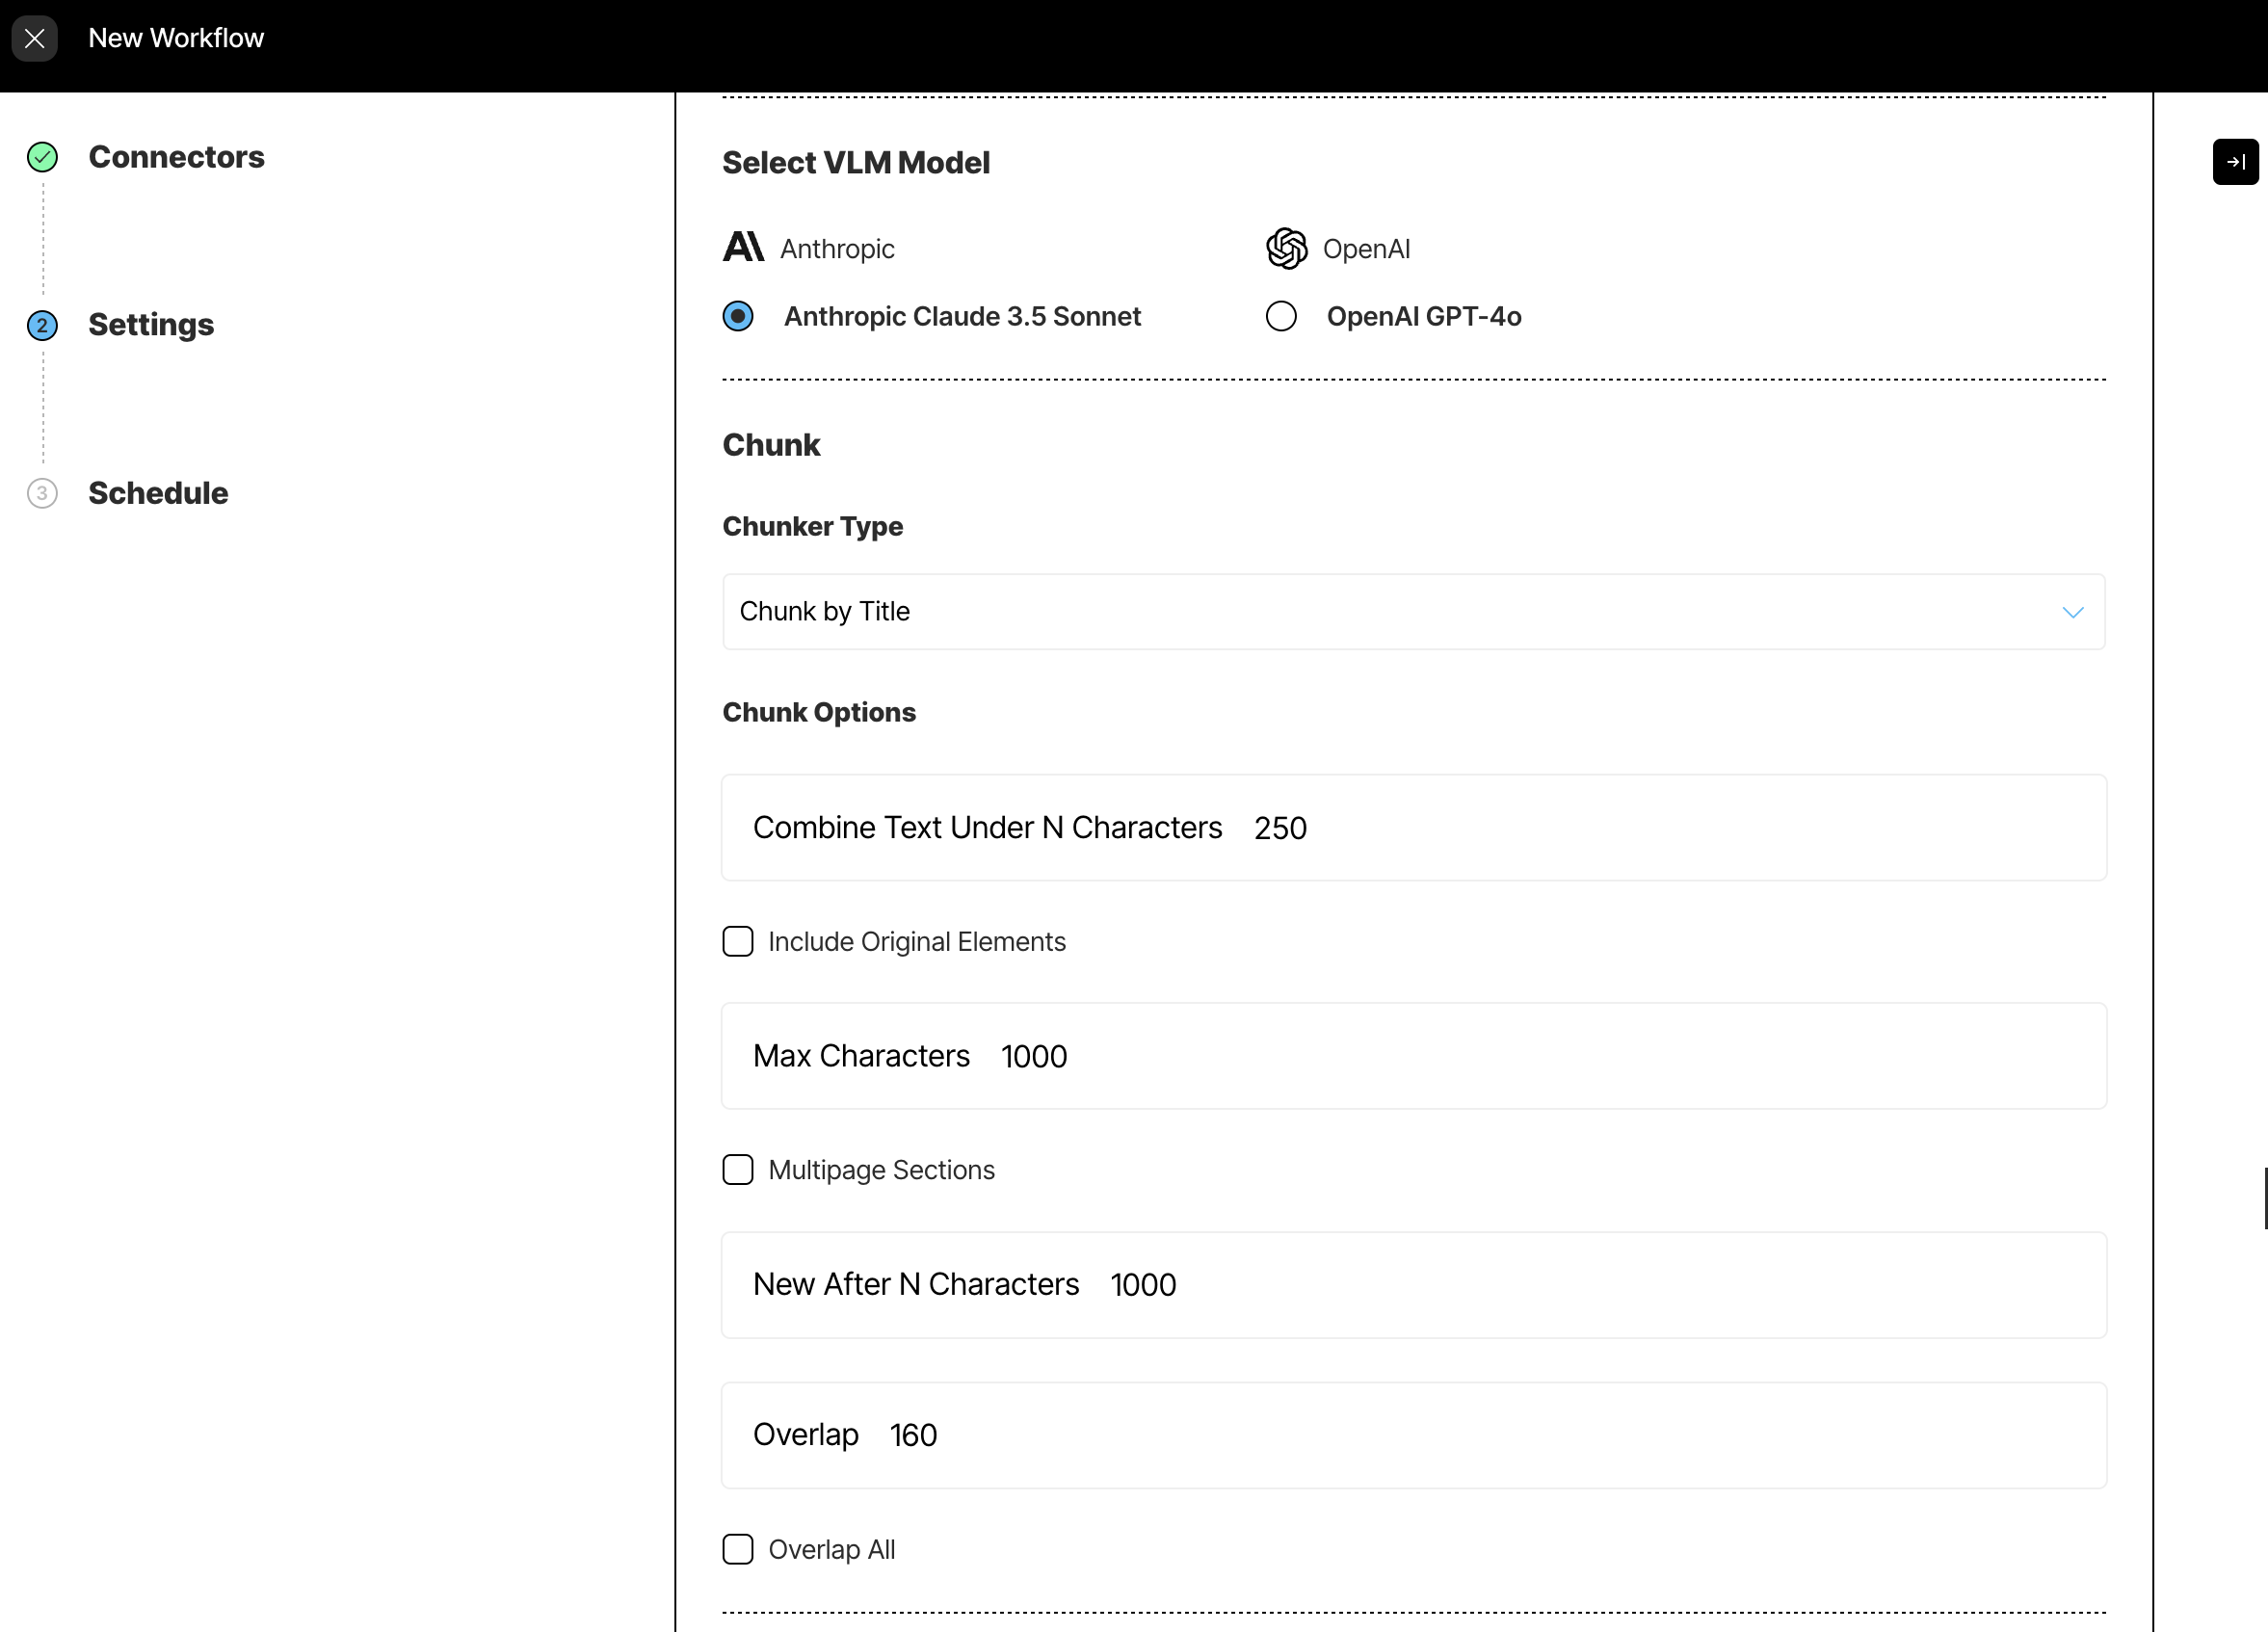

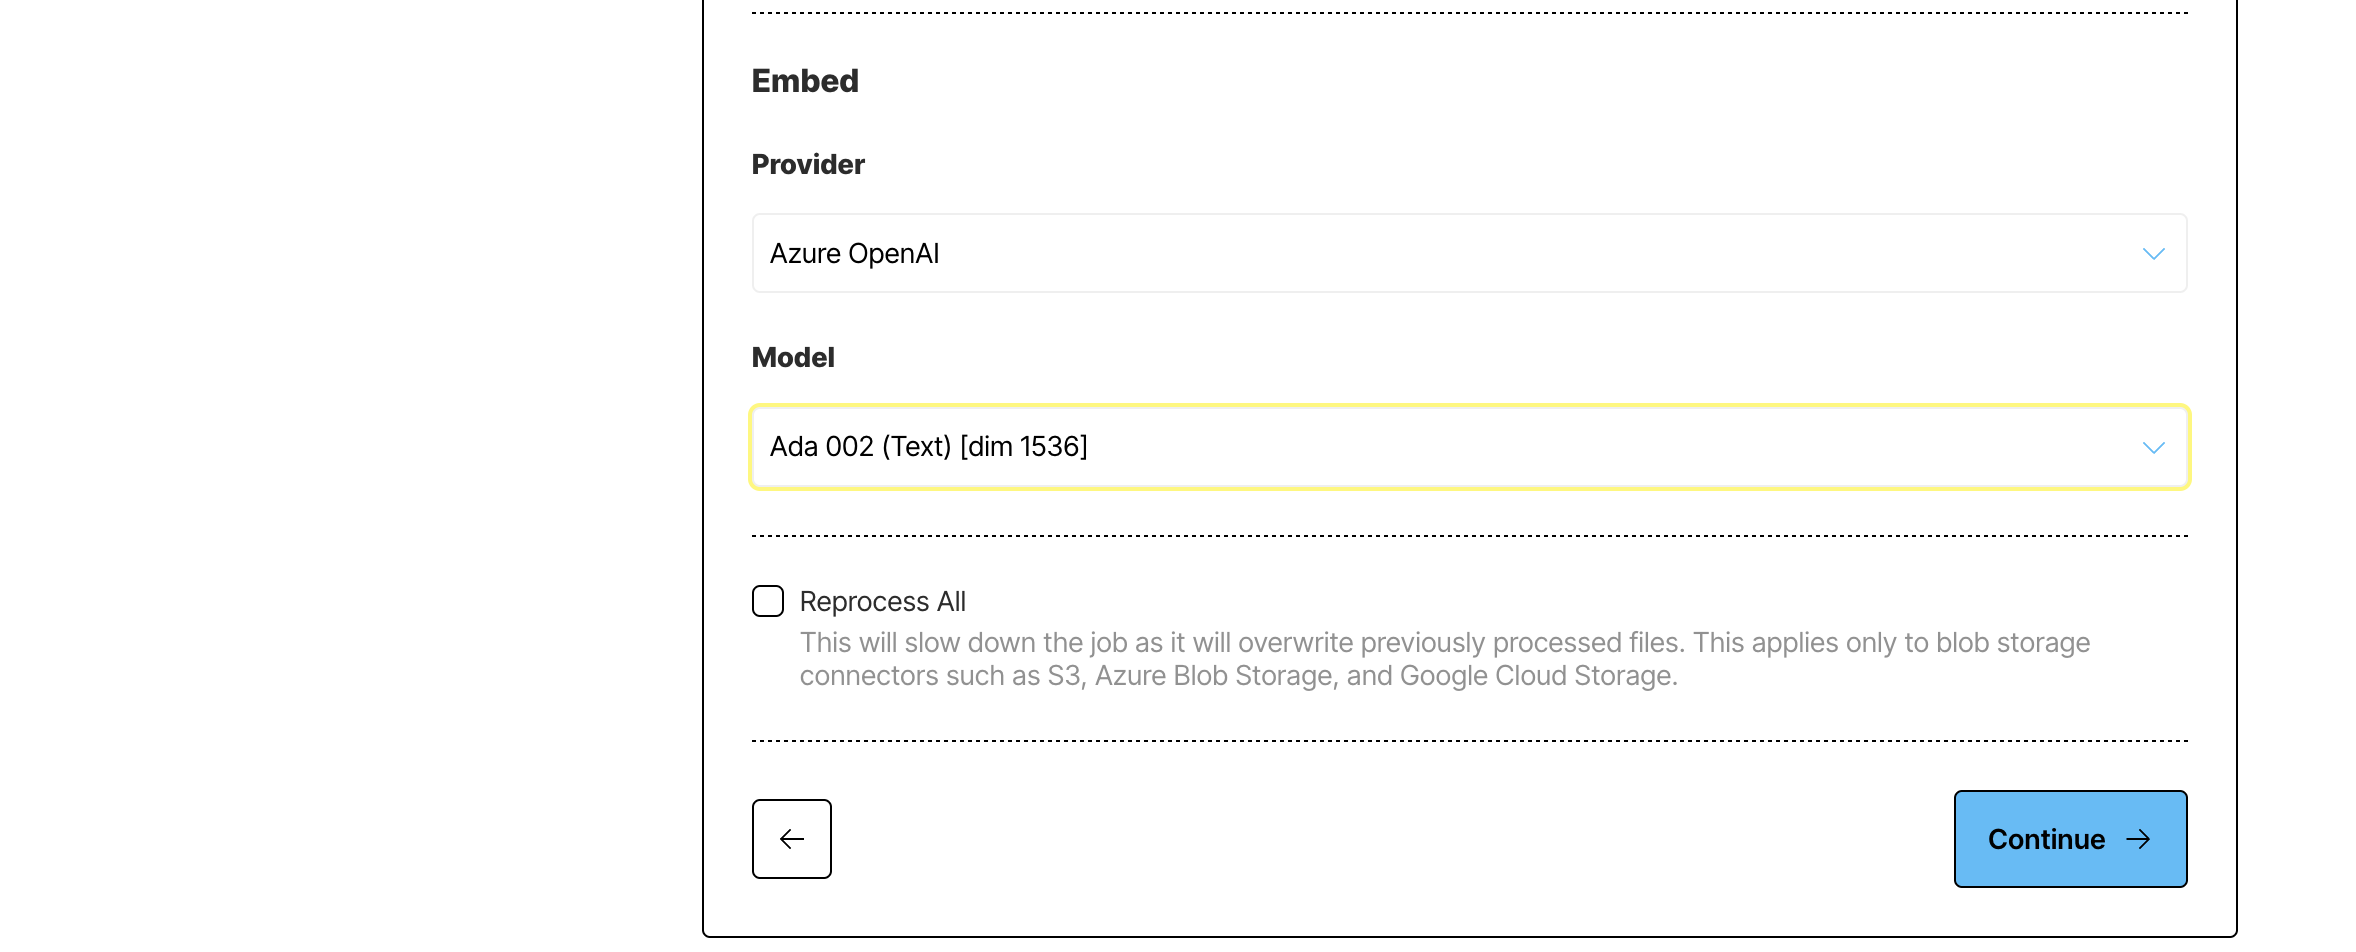

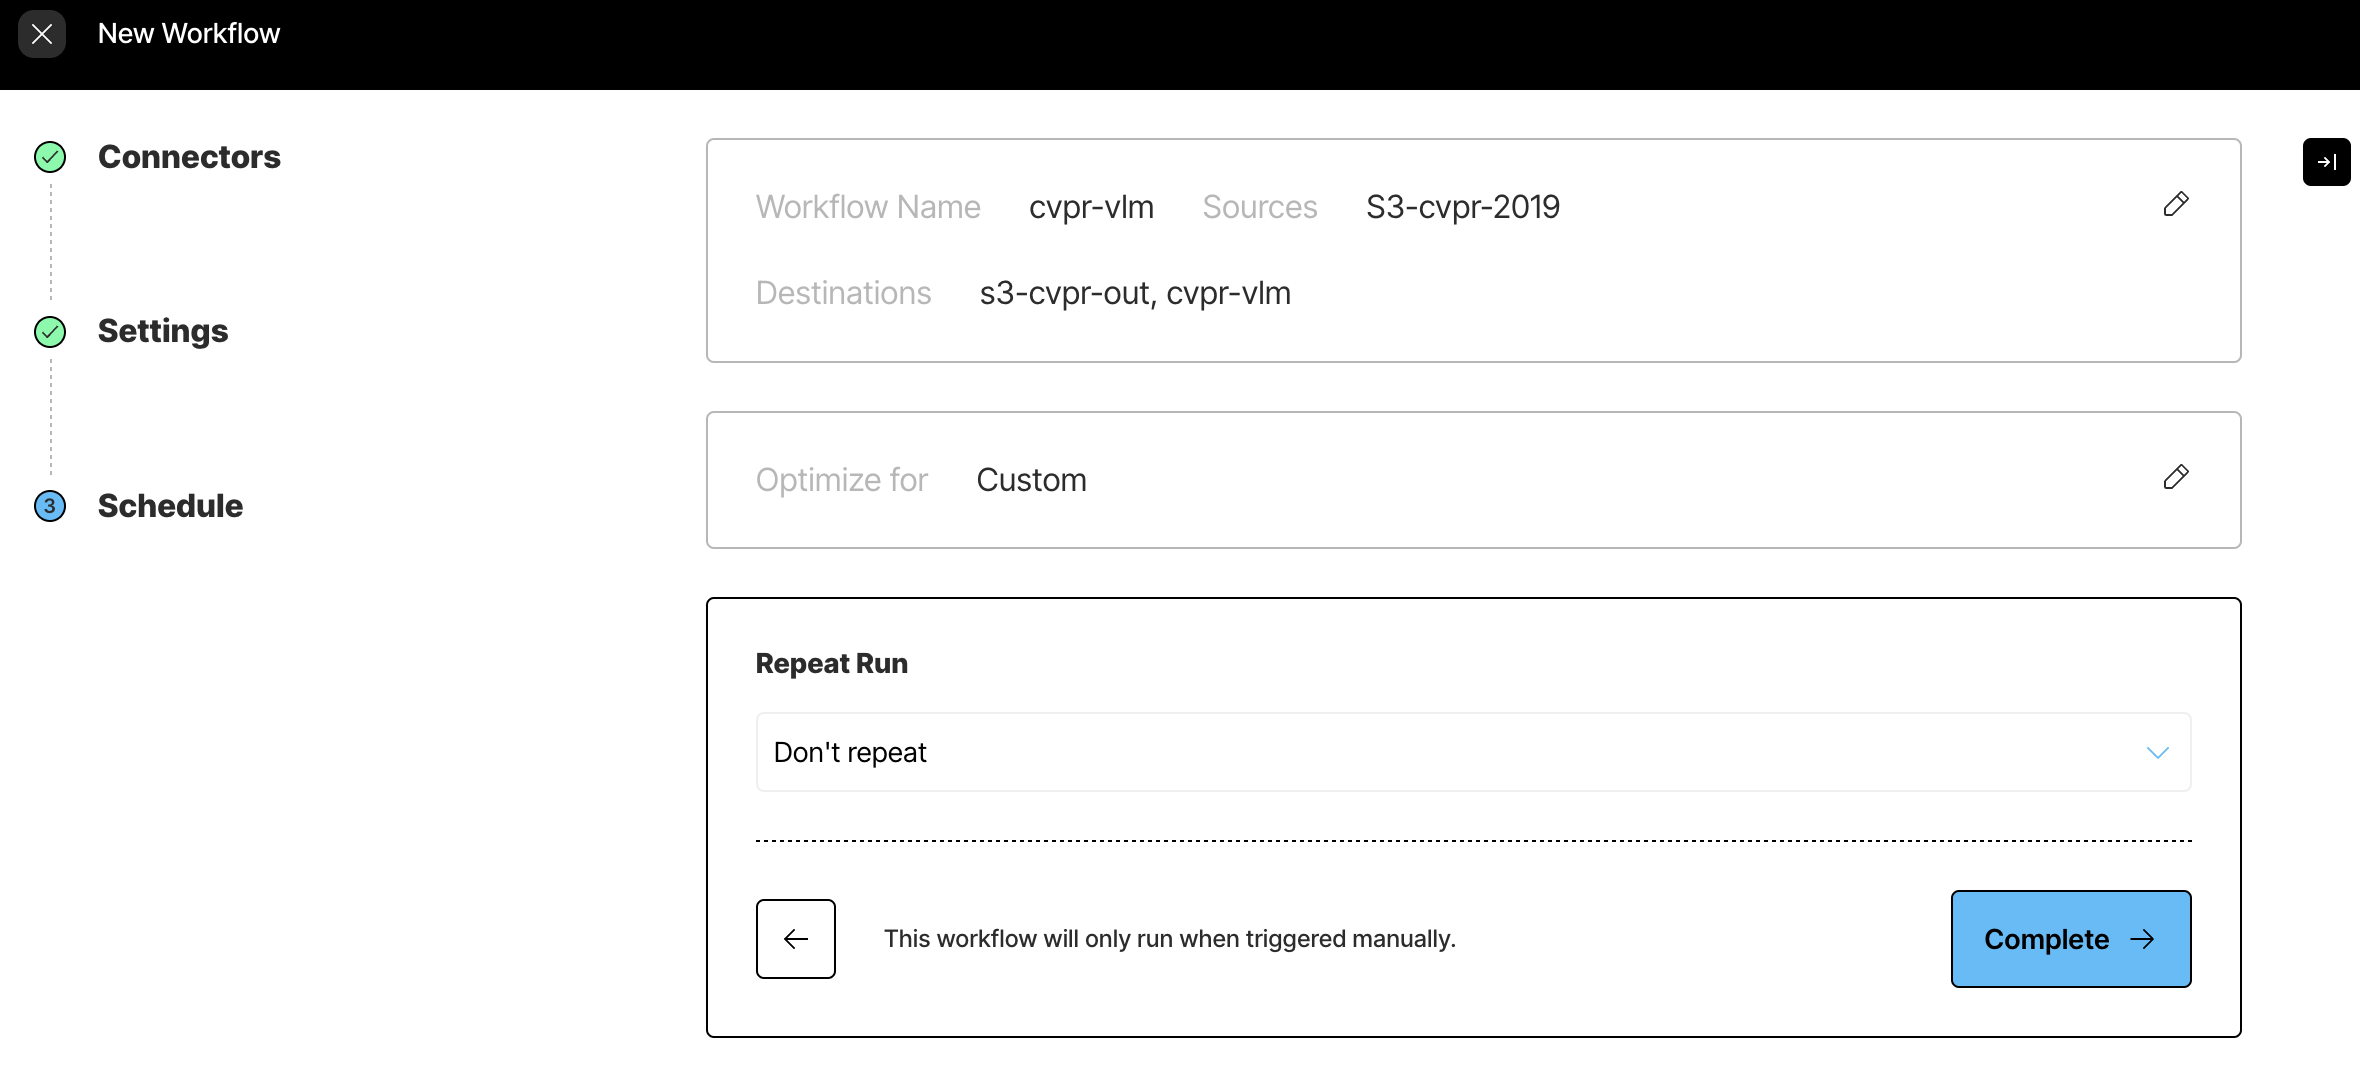

Now we run our workflow!

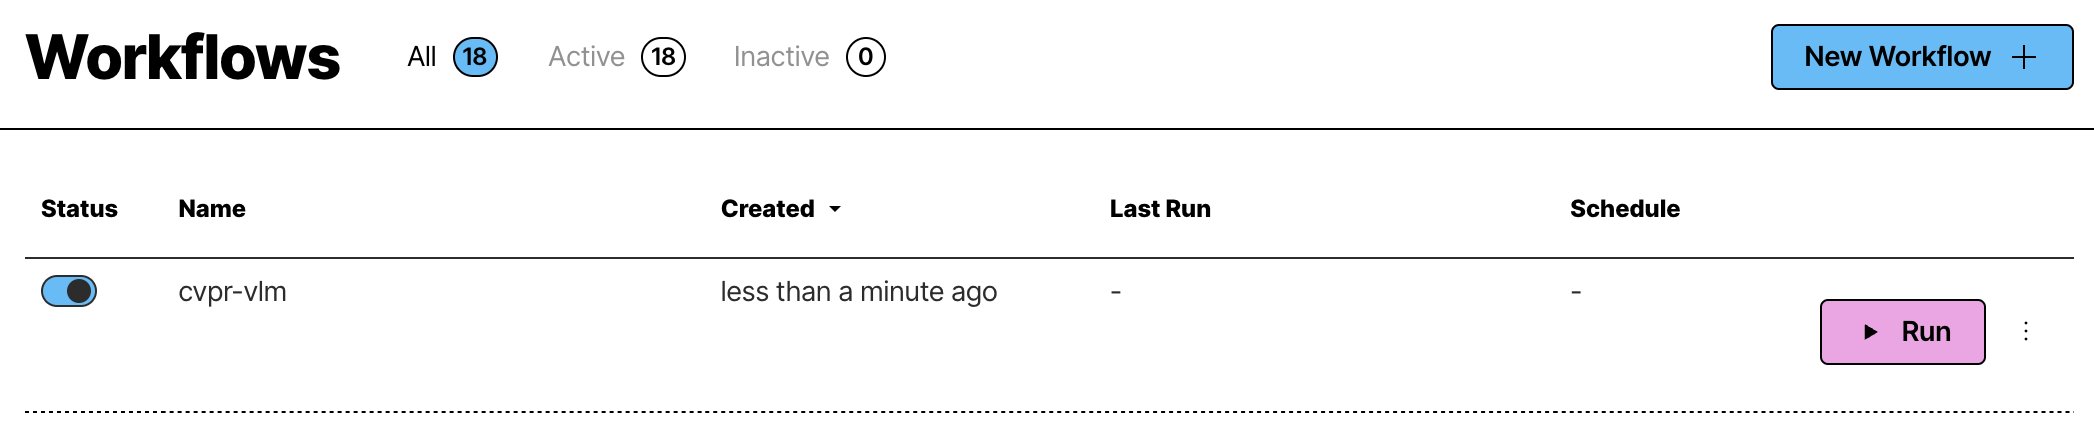

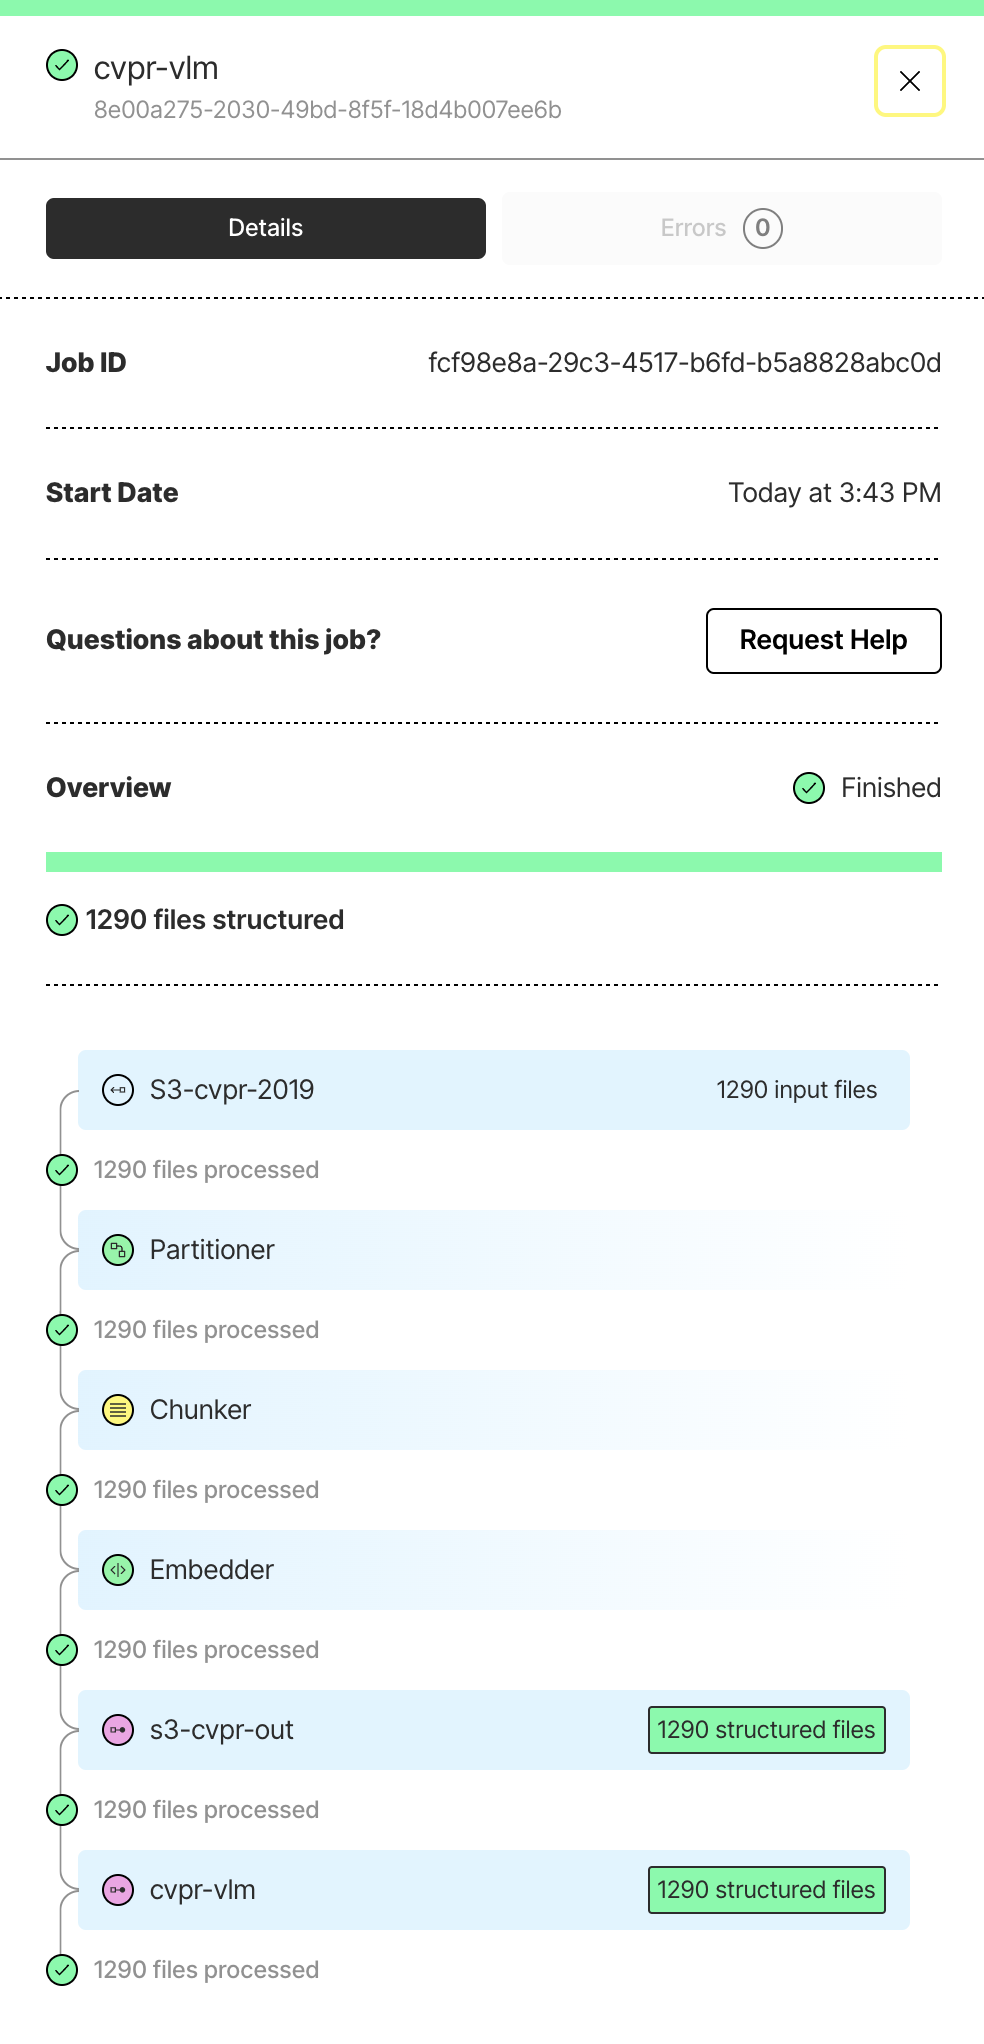

# In 10 minutes of set up and ~40 minutes of run time, I had my 1290 files both in my vector database and the json in an S3 bucket!

2. Install all the libraries to build our RAG system

In [ ]:
!pip install -q "pinecone[grpc]" pinecone-notebooks langchain transformers accelerate bitsandbytes sentence-transformers ragas boto3 rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 k

In [ ]:
#This upgrade allows Llama3.1 to be compared directly to Llama3 in the below framework
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


2. Let's import all the secret variables we need to access our data in S3 and Pinecone

In [ ]:
from google.colab import userdata
import os

# For pinecone
from pinecone_notebooks.colab import Authenticate
Authenticate()
os.environ['PINECONE_ENVIRONMENT_NAME'] = 'us-east-1'
os.environ['PINECONE_INDEX_NAME'] = 'cvpr-vlm'

# for S3
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_REGION'] = 'us-east-1'
# Specify the bucket and directory
bucket_name = 'nina-test-platform'
directory_path = 'cvpr-2019-out/'

# for Ragas
os.environ["RAGAS_APP_TOKEN"] = userdata.get("RAGAS_APP_TOKEN")

# for creating our synthetic dataset
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# For llama3.2
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [ ]:
# Define the path in Google Drive where you want to save the files
drive_path = "outputs/"

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Define the filenames for files we want to save: the test set and document elements
test_set_filename = "test_set.csv"

# Define the full paths for the test set and elements
test_set_path = os.path.join(drive_path, test_set_filename)

# Decide which model to evaluate:
model_version = 'llama3' # or another version for downstream configs

3. Load a sample file from S3 and create LangChain documents from document chunks and their metadata

In [ ]:
import os
import boto3
import random

n_files = 20

# Set up the S3 client using the environment variables
s3 = boto3.client(
    's3',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
    region_name=os.getenv('AWS_REGION'),
)

# Initialize an empty list to store file keys
file_keys = []
continuation_token = None

# Paginate through all files
while True:
    if continuation_token:
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=directory_path, ContinuationToken=continuation_token)
    else:
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=directory_path)

    # Add the file keys to the list, excluding the directory itself
    file_keys.extend(obj['Key'] for obj in response.get('Contents', []) if obj['Key'] != directory_path)

    # Check if more files are available
    if response.get('IsTruncated'):  # True if there are more files
        continuation_token = response.get('NextContinuationToken')
    else:
        break

# Print the count of files
file_count = len(file_keys)
print(f"Number of files in the directory: {file_count}")

# Download 20 random files and save their paths
downloaded_files = []
if file_keys:
    # Select 20 random files (or all if less than 20)
    files_to_download = random.sample(file_keys, min(n_files, file_count))

    for file_key in files_to_download:
        print(f"Downloading file: {file_key}")

        # Get the local filename without the directory path
        local_filename = file_key.split('/')[-1]  # Only the file name, no directories

        # Save the local filename in the list
        downloaded_files.append(local_filename)

        # Download the file to the current directory
        s3.download_file(bucket_name, file_key, local_filename)
        print(f"Downloaded {local_filename}")
else:
    print("No files found in the specified directory.")

# Print the paths of downloaded files
print(f"Downloaded files: {downloaded_files}")


Number of files in the directory: 1291
Downloaded Hussein_Timeception_for_Complex_Action_Recognition_CVPR_2019_paper.pdf.json
Downloaded Yi_MMFace_A_Multi-Metric_Regression_Network_for_Unconstrained_Face_Reconstruction_CVPR_2019_paper.pdf.json
Downloaded Johnander_A_Generative_Appearance_Model_for_End-To-End_Video_Object_Segmentation_CVPR_2019_paper.pdf.json
Downloaded Ventura_RVOS_End-To-End_Recurrent_Network_for_Video_Object_Segmentation_CVPR_2019_paper.pdf.json
Downloaded Xu_Learning_With_Batch-Wise_Optimal_Transport_Loss_for_3D_Shape_Recognition_CVPR_2019_paper.pdf.json
Downloaded Zhu_Robust_Facial_Landmark_Detection_via_Occlusion-Adaptive_Deep_Networks_CVPR_2019_paper.pdf.json
Downloaded Liu_Attribute-Aware_Face_Aging_With_Wavelet-Based_Generative_Adversarial_Networks_CVPR_2019_paper.pdf.json
Downloaded Aljundi_Task-Free_Continual_Learning_CVPR_2019_paper.pdf.json
Downloaded Pu_Iterative_Alignment_Network_for_Continuous_Sign_Language_Recognition_CVPR_2019_paper.pdf.json
Downloaded

Now we will create LangChain documents from the files we downloaded from S3

In [ ]:
import json
from langchain_core.documents import Document

# Initialize an empty list to store documents
documents = []

# Read and process each downloaded file
for local_filename in downloaded_files:
    with open(local_filename, 'r') as file:
        json_data = json.load(file)

    # Print the length of the JSON file
    print(f"Number of items in the JSON file '{local_filename}': {len(json_data)}")

    # Generate Documents from the JSON data
    for item in json_data:
        metadata = item.get('metadata', {})
        page_content = item.get('text', '')  # Assuming 'text' contains the content
        documents.append(Document(page_content=page_content, metadata=metadata))

# Print the number of documents created
print(f"Number of documents created: {len(documents)}")


Number of items in the JSON file 'Hussein_Timeception_for_Complex_Action_Recognition_CVPR_2019_paper.pdf.json': 47
Number of items in the JSON file 'Yi_MMFace_A_Multi-Metric_Regression_Network_for_Unconstrained_Face_Reconstruction_CVPR_2019_paper.pdf.json': 41
Number of items in the JSON file 'Johnander_A_Generative_Appearance_Model_for_End-To-End_Video_Object_Segmentation_CVPR_2019_paper.pdf.json': 42
Number of items in the JSON file 'Ventura_RVOS_End-To-End_Recurrent_Network_for_Video_Object_Segmentation_CVPR_2019_paper.pdf.json': 43
Number of items in the JSON file 'Xu_Learning_With_Batch-Wise_Optimal_Transport_Loss_for_3D_Shape_Recognition_CVPR_2019_paper.pdf.json': 51
Number of items in the JSON file 'Zhu_Robust_Facial_Landmark_Detection_via_Occlusion-Adaptive_Deep_Networks_CVPR_2019_paper.pdf.json': 51
Number of items in the JSON file 'Liu_Attribute-Aware_Face_Aging_With_Wavelet-Based_Generative_Adversarial_Networks_CVPR_2019_paper.pdf.json': 40
Number of items in the JSON file '

4. Import and combine Ragas + OpenAI's GPT-4o for testset generation. In this section, we will define which model to use to generate the questions and answers ('generator_llm'). We have chosen an even distribution across question types since we do not know which kinds of questions a user would ask about these data.  

In [ ]:
from ragas.testset import TestsetGenerator
from ragas.testset.synthesizers import default_query_distribution
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)

Note that this will take a few minutes to run for the 100 questions in this example and we are saving this locally to Google Drive to minimize repeated API calls.

In [ ]:
import pandas as pd
test_size = 100

# Check if the test set file exists
if not os.path.exists(test_set_path):
  # use generator.generate_with_llamaindex_docs if you use llama-index as document loader
  dataset = generator.generate_with_langchain_docs(documents, testset_size=test_size)
  test_df = dataset.to_pandas()

  # Save the test set to a CSV file
  test_df.to_csv(test_set_path, index=False)
  print("Test set saved successfully.")
else:
  print("Test set file already exists. Loading...")
  test_df = pd.read_csv(test_set_path)


Applying SummaryExtractor:   0%|          | 0/821 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/887 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/2583 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/100 [00:00<?, ?it/s]

Test set saved successfully.


In [ ]:
# Remove nan and specific phrase
clean_test = test_df[
    (test_df['user_input'].notna()) &
    (test_df['reference'] != 'nan') &
    (test_df['reference'].notna()) &
    (test_df['reference'] != 'The answer to given question is not present in context')
]
print(len(clean_test), 'filtered questions and answers in the test set')

100 filtered questions and answers in the test set


Voila, your questions and answers to evaluate your RAG system with! Let's take a look at a few as a sanity check

In [ ]:
import itertools

# Iterate over the specified number of rows
num_rows = 5
random_rows = clean_test.sample(n=num_rows)

# Iterate over the sampled rows
for index, row in random_rows.iterrows():
    print(f"Question: {row['user_input']}")
    print(f"Ground Truth: {row['reference']}")
    print("-" * 30)  # Adding a separator for better readability

Question: How does the occlusion-adaptive framework in ResNet-18 compare to the performance of ResNeXt-101 in state-of-the-art tasks?
Ground Truth: The occlusion-adaptive framework in ResNet-18 is designed to effectively handle occlusion in facial landmark detection by modifying the last residual unit to include geometry-aware, distillation, and low-rank learning modules. This framework captures geometric information and recovers missing features. In contrast, ResNeXt-101 is used in state-of-the-art tasks such as the TRECVID 2016 and 2017 AVS tasks, where it contributes to high infAP scores, although the best performance is achieved through ensemble models. The comparison highlights that while ResNet-18's occlusion-adaptive framework focuses on improving facial landmark detection under occlusion, ResNeXt-101 is part of a broader ensemble approach for achieving high performance in video retrieval tasks.
------------------------------
Question: AFLW2000-3D evaluation results?
Ground Trut

It is outside the scope of this tutorial to thoroughly evaluate these synthetic test data, however I will note that my qualitative assessment was that the questions and responses seemed reasonable and somewhat diverse

5. With your test data ready to go, we will create our Llama3.2 RAG system to evaluate

  This is a gated model, which means you first need to go to the [model's page](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct), log in, review terms and conditions, and request access to it. To use the model in the notebook, you need to log in with your Hugging Face token (get it in your profile's settings). To run this tutorial in the free Colab GPU, we'll need to quantize the model:

First we set up the retriever.


In [ ]:
from pinecone import Pinecone
from langchain.vectorstores import Pinecone as LangchainPinecone
from langchain.embeddings.openai import OpenAIEmbeddings

# Create an instance of Pinecone using your API key and environment
pc = Pinecone() # Pinecone(api_key=os.getenv('PINECONE_API_KEY')) # If logging in with a notebook API key

# Set the index name
index_name = os.getenv('PINECONE_INDEX_NAME')  # Get the index name from the environment variable

# Create the embeddings object using the same model as your index
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')  # Specify the embedding model used for your index

# Set up Pinecone vector store with the existing index
vectorstore = LangchainPinecone.from_existing_index(index_name, embeddings.embed_query)

# Create the retriever from the vectorstore
retriever = vectorstore.as_retriever()

/usr/local/lib/python3.10/dist-packages/langchain_community/vectorstores/pinecone.py:68: UserWarning: Passing in `embedding` as a Callable is deprecated. Please pass in an Embeddings object instead.
  warnings.warn(


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

if model_version == 'llama3':
  model_name = "Meta-Llama-3-8B-Instruct" # vs. "meta-llama/Meta-Llama-3.1-8B-Instruct"
elif model_version == 'llama3.1':
  model_name = "Meta-Llama-3.1-8B-Instruct"
elif model_version == 'llama3.2':
  model_name = "Llama-3.2-3B-Instruct"

print("using " + model_version + "for this RAG chain")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)


llama3


Set up Llama 3.2 and a simple RAG chain.

Make sure to follow the prompt format for best results:

```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{{ system_prompt }}<|eot_id|><|start_header_id|>user<|end_header_id|>

{{ user_msg_1 }}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{{ model_answer_1 }}<|eot_id|>
```

In [ ]:
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from typing import Dict, Any
from operator import itemgetter
from langchain.schema.runnable import RunnableParallel

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
model_path = 'meta-llama/' + model_name
model = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(model_path)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=200,
    eos_token_id=terminators,
)

llm = HuggingFacePipeline(pipeline=text_generation_pipeline)


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
prompt_template = """
<|start_header_id|>user<|end_header_id|>
You are an assistant for answering questions about a paper about machine learning you have read.
You are given the extracted parts of a long document and a question. Provide a conversational answer.
If you don't know the answer, just say "I do not know." Don't make up an answer.
Question: {question}
Context: {context}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create a function to combine context and response
def combine_context_and_response(inputs: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "response": inputs["response"],
        "context": inputs["context"],
        "question": inputs["question"]
    }

# Define the RAG chain
rag_chain = (
    RunnableParallel({
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    })
    | {
        "response": prompt | llm | StrOutputParser(),
        "context": itemgetter("context"),
        "question": itemgetter("question")
    }
    | combine_context_and_response
)


Tada! Your RAG is ready to use. Pass a question, the retriver will add relevant context from your document, and Llama3.2 will generate an answer. Here, I am using a trick question. There are several papers about computer vision in the dataset

In [ ]:
question = "What is this computer vision paper about?"
response = rag_chain.invoke(question)
response["response"]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


'Nice question! Based on what I\'ve read, this paper appears to be about developing computer vision models that can understand visual questions and answers (VQA). The title "Towards VQA Models That Can Read" suggests that the authors are working towards creating models that can comprehend text-based input and respond accordingly. The paper was presented at the IEEE Conference on Computer Vision and Pattern Recognition in 2018, which is a prominent conference in the field of computer vision. Does that sound correct?'

6. Let's generate and save responses from Llama3.2 to our test set and add them to our dataframe. Note that this took 37 minutes to run for 100 questions!

In [ ]:
answer_col = model_version + "_answer"
context_col = model_version + "_context"

if answer_col not in clean_test.columns:
  test_questions = clean_test['user_input'].tolist()
  results = rag_chain.batch(test_questions)

  # Store both responses and contexts
  for index, result in enumerate(results):
    clean_test.at[index, answer_col] = result['response']
    clean_test.at[index, context_col] = result['context']

else:
  print(answer_col +' answers already exist')

# Save the updated test set to a CSV file
clean_test.to_csv(test_set_path, index=False)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for

7. We will evaluate our systems' performance by following Ragas's [evaluation documentation](https://docs.ragas.io/en/stable/getstarted/rag_evaluation/).   

In [ ]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    LLMContextRecall,
    FactualCorrectness,
    Faithfulness,
    SemanticSimilarity,
    ContextPrecision,
    ContextRecall,
    ContextEntityRecall
)

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [ ]:
def process_and_evaluate(clean_test, answer_col, context_col, model_version, evaluator_llm, evaluator_embeddings):
    def prepare_data(df, answer_column, context_column):
        eval_data = df.copy()
        eval_data = eval_data.rename(columns={
            answer_column: 'answer',
            context_column: 'retrieved_contexts'
        })
        eval_data = eval_data[['user_input', 'reference', 'answer', 'retrieved_contexts', 'reference_contexts']]

        # Remove NaN responses
        num_nan_answers = eval_data['answer'].isna().sum()
        print(num_nan_answers, 'NaN responses removed')

        eval_data_cleaned = eval_data.dropna(subset=['answer'])
        eval_data = eval_data_cleaned

        # Ensure contexts are lists of strings
        eval_data['retrieved_contexts'] = eval_data['retrieved_contexts'].apply(
            lambda x: [x] if isinstance(x, str) else x
        )
        eval_data['reference_contexts'] = eval_data['reference_contexts'].apply(
            lambda x: [x] if isinstance(x, str) else x
        )

        # Ensure reference is a string
        eval_data['reference'] = eval_data['reference'].astype(str)

        return eval_data

    def create_dataset(eval_data):
        dataset_dict = {
            'question': eval_data['user_input'].tolist(),
            'retrieved_contexts': eval_data['retrieved_contexts'].tolist(),
            'reference_contexts': eval_data['reference_contexts'].tolist(),
            'answer': eval_data['answer'].tolist(),
            'reference': eval_data['reference'].tolist()
        }
        return Dataset.from_dict(dataset_dict)

    def run_evaluation(dataset):
        metrics = [
            # Context evaluation
            ContextPrecision(llm=evaluator_llm),      # Measures precision of retrieved contexts
            ContextRecall(llm=evaluator_llm),         # Measures recall of relevant information
            ContextEntityRecall(llm=evaluator_llm), # Measures recall of specific entities
            LLMContextRecall(llm=evaluator_llm),      # Detailed context recall with LLM

            # Answer evaluation
            FactualCorrectness(llm=evaluator_llm),    # Checks factual accuracy
            Faithfulness(llm=evaluator_llm),          # Checks if answer is supported by context

            # Similarity metrics
            SemanticSimilarity(embeddings=evaluator_embeddings)  # Semantic similarity between answer and reference
        ]

        return evaluate(dataset=dataset, metrics=metrics)

    # Main execution
    try:
        eval_data = prepare_data(clean_test, answer_col, context_col)
        dataset = create_dataset(eval_data)


        result = run_evaluation(dataset)

        print(f"\n{model_version} Results:")
        print(result)
        return result

    except Exception as e:
        print(f"Error in evaluation: {str(e)}")
        return None

Note that I have run this notebook several times, saving each model's responses and context in test_set.csv, to be able to compare models.

In [ ]:
import pandas as pd
clean_test = pd.read_csv(test_set_path)

In [ ]:
result1 = process_and_evaluate(
    clean_test,
    'llama3_answer',
    'llama3_context',
    model_version='llama3',
    evaluator_llm=evaluator_llm,
    evaluator_embeddings=evaluator_embeddings
)

0 NaN responses removed


Evaluating:   0%|          | 0/700 [00:00<?, ?it/s]


llama3 Results:
{'context_precision': 0.5700, 'context_recall': 0.4522, 'context_entity_recall': 0.2750, 'factual_correctness': 0.3122, 'faithfulness': 0.6006, 'semantic_similarity': 0.9168}


In [ ]:
result2 = process_and_evaluate(
    clean_test,
    'llama3.1_answer',
    'llama3.1_context',
    model_version='llama3.1',
    evaluator_llm=evaluator_llm,
    evaluator_embeddings=evaluator_embeddings
)

0 NaN responses removed


Evaluating:   0%|          | 0/700 [00:00<?, ?it/s]


llama3.1 Results:
{'context_precision': 0.5700, 'context_recall': 0.4655, 'context_entity_recall': 0.2681, 'factual_correctness': 0.2887, 'faithfulness': 0.6321, 'semantic_similarity': 0.9115}


In [ ]:
result3 = process_and_evaluate(
    clean_test,
    'llama3.2_answer',
    'llama3.2_context',
    model_version='llama3.2',
    evaluator_llm=evaluator_llm,
    evaluator_embeddings=evaluator_embeddings
)

0 NaN responses removed


Evaluating:   0%|          | 0/700 [00:00<?, ?it/s]


llama3.2 Results:
{'context_precision': 0.5900, 'context_recall': 0.4947, 'context_entity_recall': 0.2789, 'factual_correctness': 0.2842, 'faithfulness': 0.5896, 'semantic_similarity': 0.9070}


If we want to see the evaluator model's reasoning behind judgments and dive deeper into the results, we can upload our files to [Ragas app](https://app.ragas.io/)

In [ ]:
result3.upload()

Evaluation results uploaded! View at https://app.ragas.io/dashboard/alignment/evaluation/47639658-5025-4c28-8a28-2f4a310d517f


'https://app.ragas.io/dashboard/alignment/evaluation/47639658-5025-4c28-8a28-2f4a310d517f'

8. Let's take a look at the results we previewed at the start!

Metrics DataFrame:
╒═══════════════════════╤════════════════════════════╤══════════════════════════════╤═════════════════════════╕
│                       │   Meta-Llama-3-8B-Instruct │   Meta-Llama-3.1-8B-Instruct │   Llama-3.2-3B-Instruct │
╞═══════════════════════╪════════════════════════════╪══════════════════════════════╪═════════════════════════╡
│ faithfulness          │                     0.6006 │                       0.6321 │                  0.5896 │
├───────────────────────┼────────────────────────────┼──────────────────────────────┼─────────────────────────┤
│ semantic_similarity   │                     0.9168 │                       0.9115 │                  0.9070 │
├───────────────────────┼────────────────────────────┼──────────────────────────────┼─────────────────────────┤
│ factual_correctness   │                     0.3122 │                       0.2887 │                  0.2842 │
├───────────────────────┼────────────────────────────┼──────────────────────────────┼

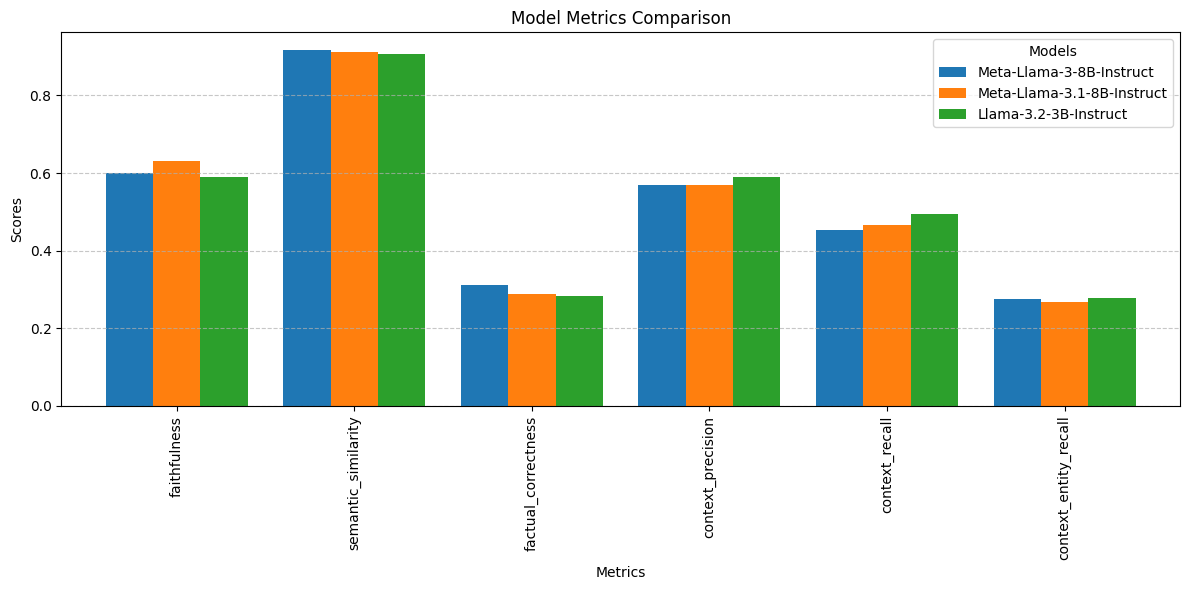

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Full model names for reference
model_names = {
    "Llama3": "Meta-Llama-3-8B-Instruct",
    "Llama3.1": "Meta-Llama-3.1-8B-Instruct",
    "Llama3.2": "Llama-3.2-3B-Instruct"
}

# Metrics to compute
metrics = [
    "faithfulness",  "semantic_similarity", "factual_correctness",
    "context_precision", "context_recall", "context_entity_recall"
]

# Helper function to compute mean of a metric
def compute_mean(result, metric):
    try:
        values = result[metric]  # Access the list of values for the metric
        return np.mean(values)  # Compute mean
    except KeyError:
        print(f"Metric '{metric}' not found in the result.")
        return None
    except Exception as e:
        print(f"Error computing mean for metric '{metric}': {e}")
        return None

# Combine all results and compute mean for each model
model_data = {}

# Process results for Llama3
model_data[model_names["Llama3"]] = {
    metric: compute_mean(result1, metric) for metric in metrics
}

# Process results for Llama3.1
model_data[model_names["Llama3.1"]] = {
    metric: compute_mean(result2, metric) for metric in metrics
}

# Process results for Llama3.2
model_data[model_names["Llama3.2"]] = {
    metric: compute_mean(result3, metric) for metric in metrics
}

# Convert to DataFrame and drop metrics with all None values
df = pd.DataFrame.from_dict(model_data, orient="index").T
df = df.dropna(how="all")  # Remove rows with all None values

# Display metrics table
print("Metrics DataFrame:")
print(tabulate(df, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))

# Visualize metrics
df.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.title("Model Metrics Comparison")
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.legend(title="Models")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


Let's look at a box & whiskers plot to see if this is more informative

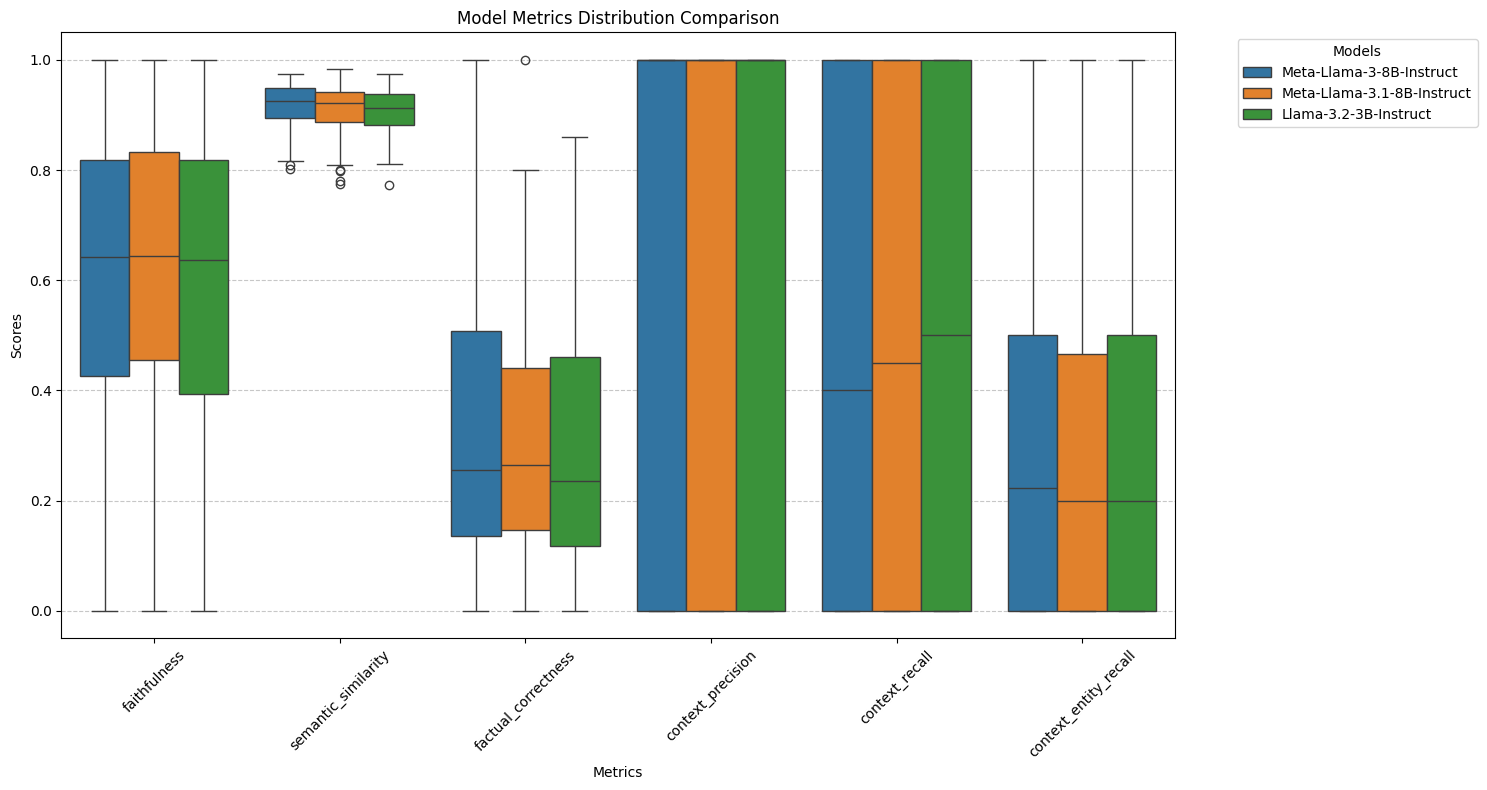

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Full model names for reference
model_names = {
    "Llama3": "Meta-Llama-3-8B-Instruct",
    "Llama3.1": "Meta-Llama-3.1-8B-Instruct",
    "Llama3.2": "Llama-3.2-3B-Instruct"
}

# Metrics to analyze
metrics = [
    "faithfulness", "semantic_similarity", "factual_correctness",
    "context_precision", "context_recall", "context_entity_recall"
]

# Create a list to store all data for box plots
all_data = []

# Process results for each metric
for metric in metrics:
    try:
        # Get values for each model
        llama3_values = result1[metric]  # Direct access to the metric values
        llama31_values = result2[metric]
        llama32_values = result3[metric]

        # Add data to the list with corresponding model and metric labels
        for value in llama3_values:
            all_data.append({'Model': model_names['Llama3'], 'Metric': metric, 'Value': value})
        for value in llama31_values:
            all_data.append({'Model': model_names['Llama3.1'], 'Metric': metric, 'Value': value})
        for value in llama32_values:
            all_data.append({'Model': model_names['Llama3.2'], 'Metric': metric, 'Value': value})

    except KeyError as e:
        print(f"Metric '{metric}' not found in results: {e}")
    except Exception as e:
        print(f"Error processing metric '{metric}': {e}")

# Convert to DataFrame
df2 = pd.DataFrame(all_data)

# Create box plots
plt.figure(figsize=(15, 8))
sns.boxplot(data=df2, x='Metric', y='Value', hue='Model')
plt.title("Model Metrics Distribution Comparison")
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig('boxplot.png', bbox_inches='tight', dpi=300)
plt.show()

These results are interesting: On earlier runs, where I only generated questions from 1 file, and only had that file in my retriever, there were more stark differences between the models. This tells me that I should try several next steps to improve the retriever + overall RAG system performance before coming back to comparing models. Some next steps to try are:



1.   Hybrid search instead of semantic similarity
2.   Metadata filters
3.   Retrieve more documents + rerank
4.   Try different chunking + embedding strategies



Overall this is a great start to quickly get a sense of which models are candidates for RAG in production! After the next steps above, I would create a much larger test set, run a more comprehensive query using my candidate model + RAG setup, and evaluate the results more thoroughly.  